# Intro to Neural Networks
## Assignment 1
### Mohsin Mohammed


In [5]:
# Loading the dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.regularizers import l2
import keras_tuner
%matplotlib inline 
import keras
from tensorflow.keras.callbacks import TensorBoard
import datetime

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "Could not find TensorRT")



In [6]:
#Loading the dataset
data = pd.read_csv('https://raw.githubusercontent.com/momokamalz/neural_networks/main/insurance.csv')

In [7]:
# Printing the first five rows of the dataset 
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We have a combination of categorical and numerical features.

## 1. Exploratory Data Analysis

In [8]:
# Data preprocessing
def check_missing_values(df):
    return df.isnull().sum()

check_missing_values(data)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
# looking for duplicates
def check_duplicates(df):
    return df.duplicated().sum()

duplicates = check_duplicates(data)
duplicates

1

In [10]:
# Lets drop this duplicated row:
data = data.drop_duplicates()

# lets check for duplicates again to confirm that they have been deleted
duplicates = check_duplicates(data)
duplicates

0

In [11]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


our dataset does not have any missing values. So we can continue with other preprocessing methods.

In [12]:
# Lets check the data types 
def categorical_features(df):
    """ param df is a dataframe
    retuns a list of categorical features"""
    return df.select_dtypes(exclude=np.number).columns.tolist()

categorical_features(data)

['sex', 'smoker', 'region']

observation: Our categorical data is nominal as it does not follow any inherent order or sequence. There is no heirarchy associated between these features. For example, males and females have no order associated with them and the encoding technique we use should make sure that it does not associate an order with the categorical features. We can use one hot encoding or pandas, create dummies to accomplish this task.

In [13]:
def numerical_features(df):
    return df.select_dtypes(include=np.number).columns.tolist()

numerical_features(data)

['age', 'bmi', 'children', 'charges']

The numerical features are 'age', 'bmi', 'children' which are independent and the dependent variable is 'charges'.

In [14]:
# Lets check how many unique values and the value counts we have in our categorical features
def unique_vals(df):
    result = df.select_dtypes(exclude=np.number).value_counts()
    result_df = result.to_frame().reset_index()
    result_df.columns = ['sex', 'smoker', 'region', 'count']
    return result_df

unique_vals(data)


,sex,smoker,region,count
0,female,no,southwest,141
1,female,no,southeast,139
2,female,no,northwest,135
3,male,no,southeast,134
4,female,no,northeast,132
5,male,no,northwest,131
6,male,no,southwest,126
7,male,no,northeast,125
8,male,yes,southeast,55
9,male,yes,northeast,38


It appears that the majority of our distribution consists of females with a count of 141 that happen to be from southwest region and are non smokers. 
We can also see that the lowest number of female smokers are from the southwest region totalling 21.
Similarly, we can look at our dataframe and get a good understanding of our distribution about the other categorical features. 
We can confirm this by using the query method to verify this fact below:

In [15]:
example = data.query("sex == 'female' and smoker == 'no' and region == 'southwest'")
example.shape[0]   # prints the number of rows.

141

In [16]:
example_2 = data.query("sex == 'female' and smoker == 'yes' and region == 'southwest'")
example_2.shape[0]

21

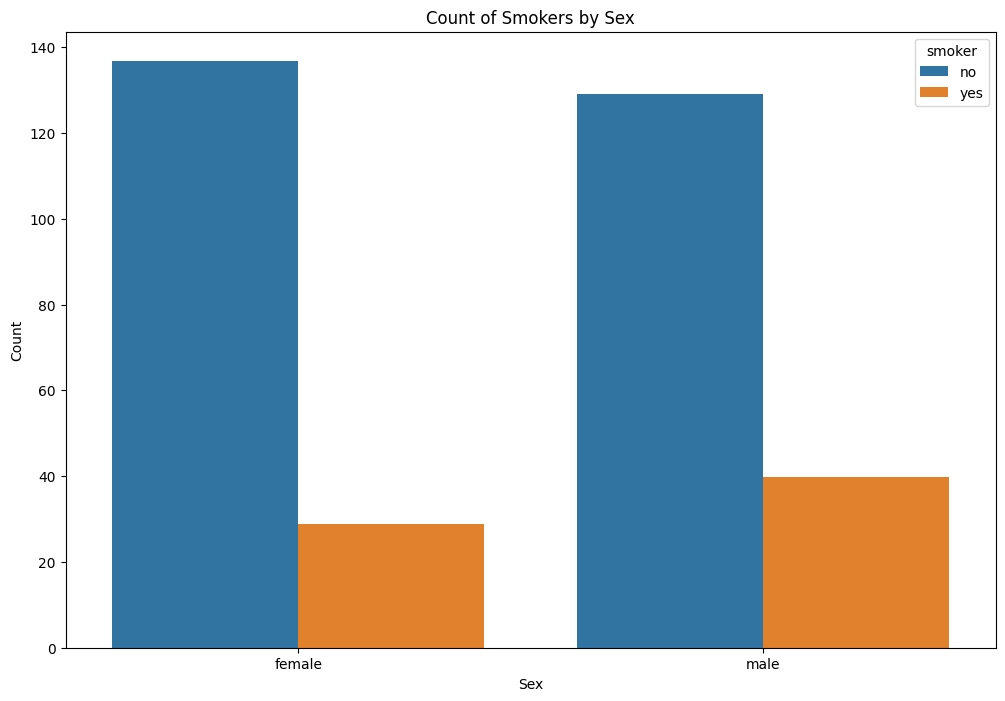

In [17]:
# Lets create a bar plot to visualize this data frame:
cat_df = unique_vals(data)

plt.figure(figsize=(12,8))
sns.barplot(data=cat_df, x='sex', y='count', hue='smoker', errorbar=None)
plt.title('Count of Smokers by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

It appears that our data set consists of predominantly non smokers across both the genders. We can also deduce that we have more male population that smoke compared to the female population in our dataset.

Lets also repeat this step to vizualize the count of sex by region:

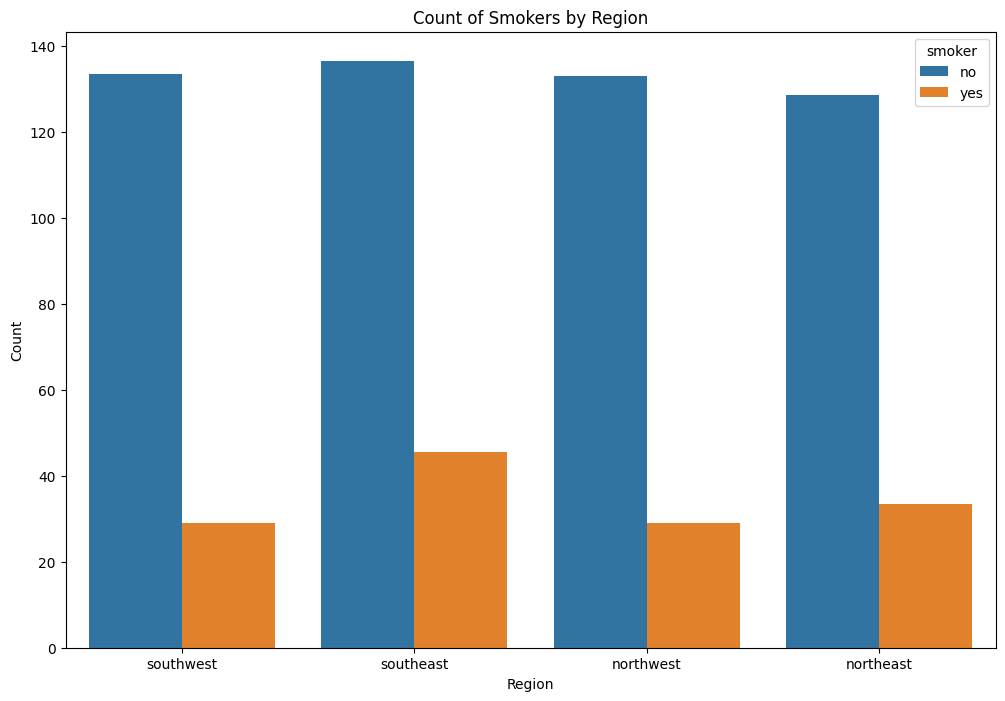

In [18]:
plt.figure(figsize=(12,8))
sns.barplot(data=cat_df, x='region', y='count', hue='smoker', errorbar=None)
plt.title('Count of Smokers by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

We can see from our barplot that the southeast region has the most amount of smokers in our dataset. Lets see if the southeast region pays the most in charges since a majority of smokers are from this region.

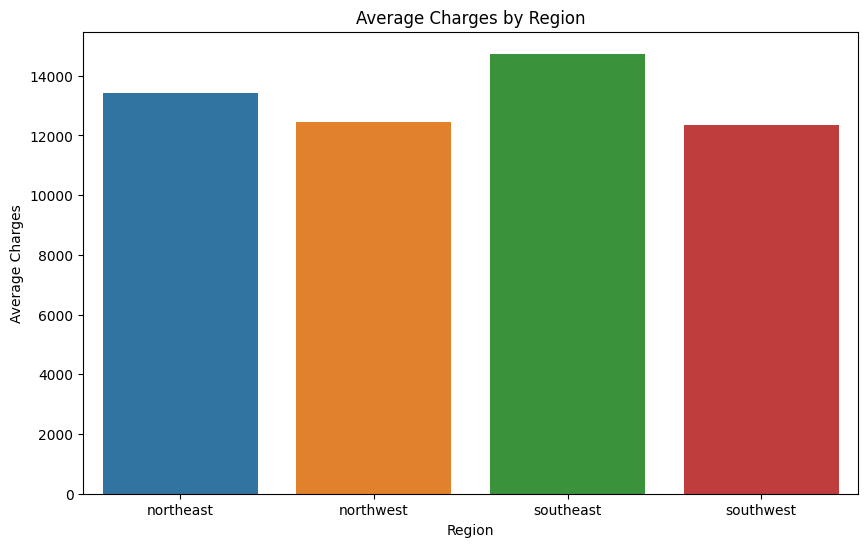

In [26]:
average_charges_by_region = data.groupby('region')['charges'].mean().reset_index()
# colors = ["red", "orange", "blue", "green"]
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='charges', data=average_charges_by_region, hue='region', legend=False)
plt.title("Average Charges by Region")
plt.xlabel('Region')
plt.ylabel('Average Charges')
plt.show()

We were correct in assuming that the Southeast region that has the most amount of smokers pay the most. 
Since the highest number of smokers are from the southeast region, they pay more in charges in average compared to other regions.

<Axes: xlabel='sex', ylabel='count'>

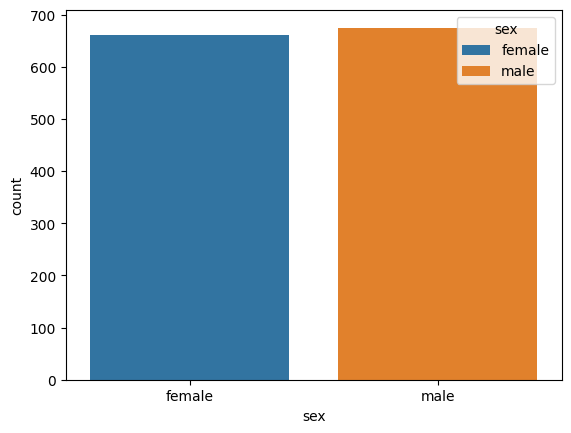

In [29]:
# Lets plot the distribution of the males and females in our dataset

sns.countplot(data=data, x='sex', hue='sex', legend=True)

In [30]:
def gender_distribution(df):
    result = df.sex.value_counts()
    result_df = result.to_frame().reset_index()
    result_df.columns = ['sex', 'count']
    return result_df

gender_distribution(data)

,sex,count
0,male,675
1,female,662


Lets plot the correlation between our features and find any patterns:

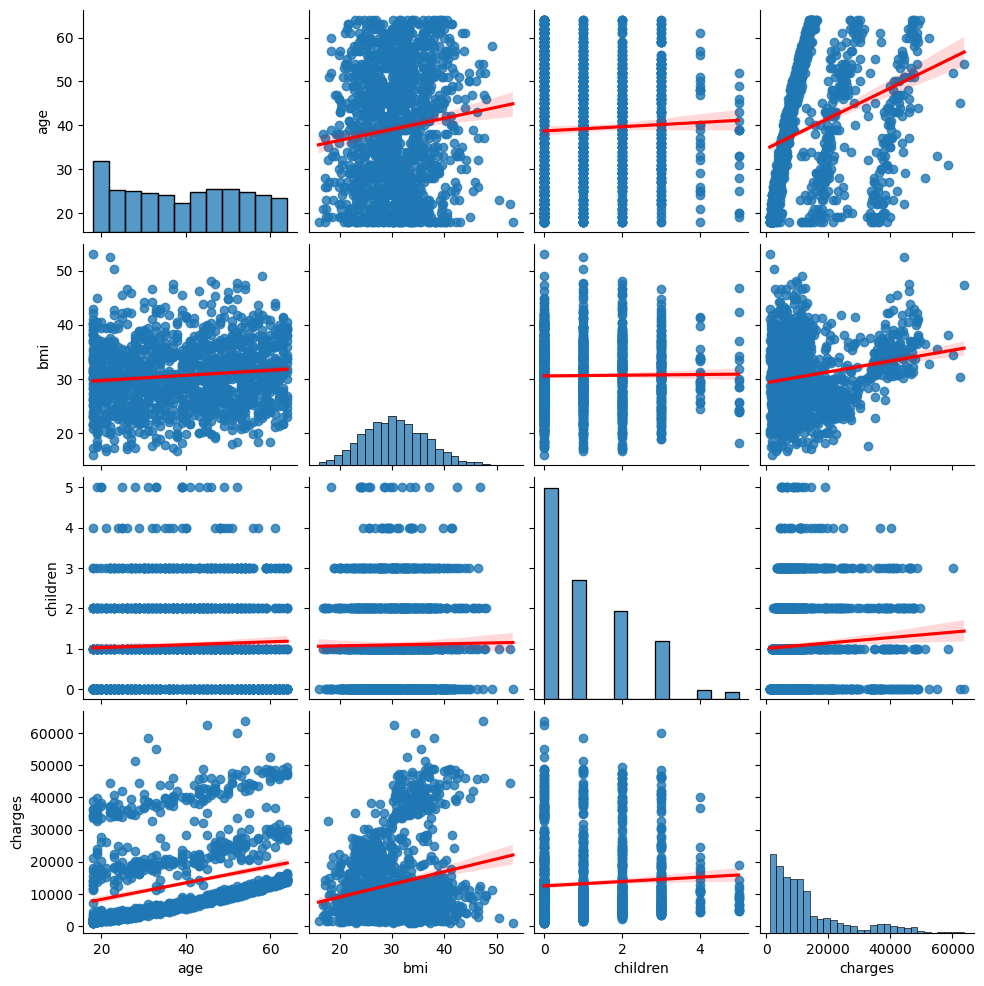

In [31]:
sns.pairplot(data,  kind="reg", 
            plot_kws={'line_kws':{'color':'red'}})
plt.show()

A pair plot of the features reveals that age is correlated with charges as there seems to be a linear relationship. We can observe that as age increases, we also see an increse in charges. 

We can confirm this by doing an individual scatter plot as follows:

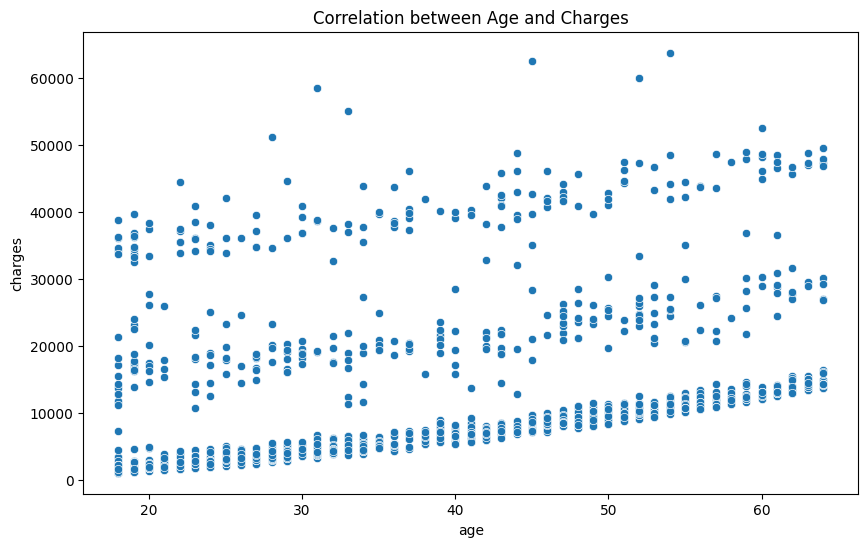

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x='age', y='charges')
plt.title("Correlation between Age and Charges")
plt.show()

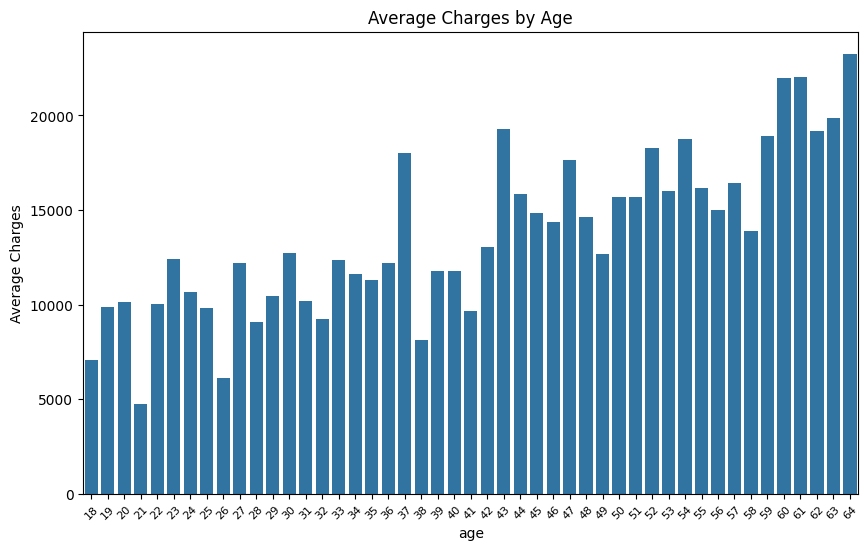

In [33]:
average_charges_by_age = data.groupby('age')['charges'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='age', y='charges', data=average_charges_by_age)
plt.title("Average Charges by Age")
plt.xlabel('age')
plt.ylabel('Average Charges')
plt.xticks(rotation=45, fontsize=8)
plt.show()

We can see that the users pay more in average charges as they get older.

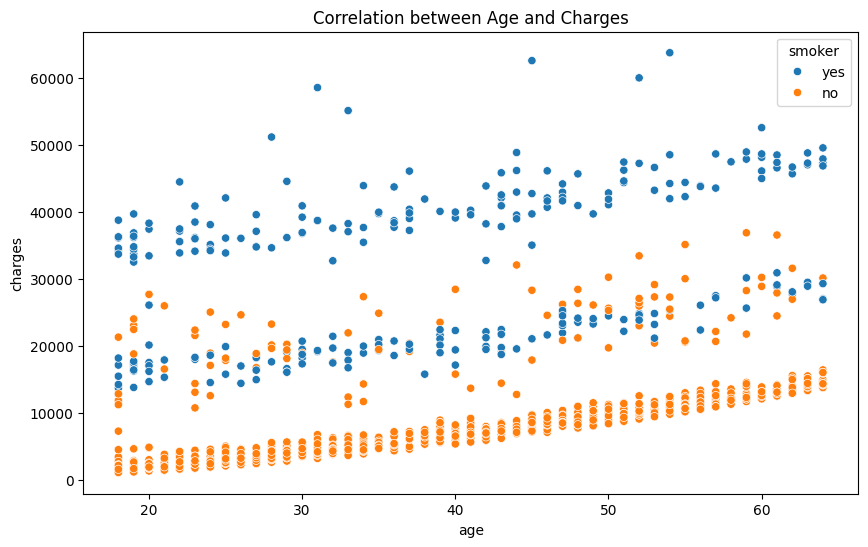

In [34]:
# Lets add the smoker category to age and analyze if being a smoker affects the charges:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x='age', y='charges', hue='smoker')
plt.title("Correlation between Age and Charges")
plt.show()

We can clearly see that smokers pay more in charges depicted by the blue dots. compared to the non smokers. While we can see a clear linear relationship between age and charges, 
we can also see that people that are smokers and also pay more as their age increases. This means that there is correlation between smokers and age. 
We can confirm this after we scale the categorical features using one hot encoding and displaying a heat map of all the correlations.

## 2. Pre Processing Data: Data Transformations 
### Perform all the steps that are crucial for ensuring that the data fed into your models is of high quality and suitable for your needs.
### Lets use One Hot Encoding to encode our categorical features. 

In [35]:
def one_hot_encoder(df):
    """ 
    params: df is a dataframe
    returns an encoded dataframe of all the categorical features
    """
    category_columns = df.select_dtypes(exclude=np.number).columns.tolist()
    encoder = OneHotEncoder()
    category_columns_encoded = encoder.fit_transform(df[category_columns]).toarray()
    category_columns_encoded_df = pd.DataFrame(data=category_columns_encoded, columns=encoder.get_feature_names_out(category_columns))
    return category_columns_encoded_df

category_cols_encoded_df = one_hot_encoder(data)
category_cols_encoded_df

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1332,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1333,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1334,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1335,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Lets drop the categorical columns from the original dataset so we can add the encoded features to the original dataset. 


In [36]:
# def drop categorical features
def drop_categorical_features(df):
    categorical_columns = df.select_dtypes(exclude=np.number)
    drop_categorical_cols = df.drop(categorical_columns, axis=1)
    return drop_categorical_cols


numerical_features_df = drop_categorical_features(data)
numerical_features_df



,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


Lets plot the distribution of our features to understand which scaling technique to use for our numerical features.

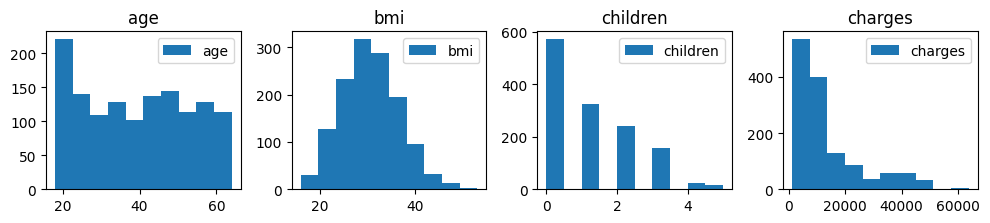

In [24]:
def plot_distribution(df):
    plt.figure(figsize=(10, 8))
    try:
        for i, col in enumerate(df.columns.to_list()):
            plt.subplot(4, 4, i + 1)
            plt.hist(df[col], label=col)
            plt.legend()
            plt.title(col)
            plt.tight_layout()
    except Exception as e:
        print(col,e)

plot_distribution(numerical_features_df)

Since our numerical features do not follow a gaussian distribution, we will use the min max scaler to scale our numerical features.
If our distribution across all the featuresd was normally distributed, we could've used standard scaler to scale our data. 

In [37]:
def min_max_scaler(df):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled, columns=df.columns)
    return scaled_df

# dropping the target varibale so we can scale the X features for our NN model
numerical_df = numerical_features_df.drop(['charges'], axis=1)

numerical_scaled_df = min_max_scaler(numerical_df)

numerical_scaled_df.head()


# numerical_scaled_df = min_max_scaler(numerical_features_df)
# numerical_scaled_df.head()


,age,bmi,children
0,0.021739,0.321227,0.0
1,0.000000,0.479150,0.2
2,0.217391,0.458434,0.6
3,0.326087,0.181464,0.0
4,0.304348,0.347592,0.0


In [38]:
# Lets add the one hot encoded  categorical features and the numerical features together for further analyses
def concat_numerical_categorical(df_1, df_2):
    return pd.concat([df_1, df_2], axis=1)

x_scaled_df = concat_numerical_categorical(category_cols_encoded_df, numerical_scaled_df)
x_scaled_df

# x_scaled_df = concat_numerical_categorical(category_cols_encoded_df, numerical_scaled_df)
# x_scaled_df.head()

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age,bmi,children
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.021739,0.321227,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.479150,0.2
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.217391,0.458434,0.6
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.326087,0.181464,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.304348,0.347592,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1332,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.695652,0.403820,0.6
1333,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.429379,0.0
1334,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.562012,0.0
1335,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.065217,0.264730,0.0


In [39]:
target = data[['charges']].reset_index(drop=True)
target

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520
...,...
1332,10600.54830
1333,2205.98080
1334,1629.83350
1335,2007.94500


In [40]:
# adding the x features and the target class together into a dataframe:
final_df = pd.concat([x_scaled_df, target], axis=1)
final_df

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age,bmi,children,charges
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.021739,0.321227,0.0,16884.92400
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.479150,0.2,1725.55230
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.217391,0.458434,0.6,4449.46200
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.326087,0.181464,0.0,21984.47061
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.304348,0.347592,0.0,3866.85520
...,...,...,...,...,...,...,...,...,...,...,...,...
1332,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.695652,0.403820,0.6,10600.54830
1333,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.429379,0.0,2205.98080
1334,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.562012,0.0,1629.83350
1335,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.065217,0.264730,0.0,2007.94500


In [41]:
# lets check the correlation of our features:
def find_correlation(df):
    return df.corr()

df_correlation = find_correlation(final_df)
df_correlation

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age,bmi,children,charges
sex_female,1.000000,-1.000000,0.076596,-0.076596,0.002008,0.012482,-0.017578,0.003767,0.019814,-0.046397,-0.017848,-0.058044
sex_male,-1.000000,1.000000,-0.076596,0.076596,-0.002008,-0.012482,0.017578,-0.003767,-0.019814,0.046397,0.017848,0.058044
smoker_no,0.076596,-0.076596,1.000000,-1.000000,-0.002597,0.036321,-0.068282,0.037168,0.025587,-0.003746,-0.007331,-0.787234
smoker_yes,-0.076596,0.076596,-1.000000,1.000000,0.002597,-0.036321,0.068282,-0.037168,-0.025587,0.003746,0.007331,0.787234
region_northeast,0.002008,-0.002008,-0.002597,0.002597,1.000000,-0.319842,-0.345909,-0.320493,0.001868,-0.138178,-0.023202,0.005945
region_northwest,0.012482,-0.012482,0.036321,-0.036321,-0.319842,1.000000,-0.345909,-0.320493,0.001495,-0.136138,0.026044,-0.038695
region_southeast,-0.017578,0.017578,-0.068282,0.068282,-0.345909,-0.345909,1.000000,-0.346614,-0.012311,0.270057,-0.023492,0.073578
region_southwest,0.003767,-0.003767,0.037168,-0.037168,-0.320493,-0.320493,-0.346614,1.000000,0.009415,-0.006211,0.021538,-0.043637
age,0.019814,-0.019814,0.025587,-0.025587,0.001868,0.001495,-0.012311,0.009415,1.000000,0.109344,0.041536,0.298308
bmi,-0.046397,0.046397,-0.003746,0.003746,-0.138178,-0.136138,0.270057,-0.006211,0.109344,1.000000,0.012755,0.198401


we can see that the smoker_yes column has the highest correlation of 0.78 with charges which means that smokers pay a lot of charges in insurance.
We can also see that age feature is the second feature that has the highest correlation with charges after charges.
We can also see that the third feature that is correlated with charges is bmi. 

All these observations were noted earlier in our data visualizations.


In [42]:
# dividing the dataset into train, test, validate with 0.6, 0.2, 0.2
X, X_test, y, y_test = train_test_split(x_scaled_df, target, test_size=0.2, train_size=0.8, random_state=42)

X_train, X_validate, y_train, y_validate = train_test_split(X, y,test_size = 0.25, train_size =0.75, random_state=42)



In [43]:
X_train.shape, X_test.shape, X_validate.shape

((801, 11), (268, 11), (268, 11))

In [44]:
y_train.shape, y_test.shape, y_validate.shape

((801, 1), (268, 1), (268, 1))

## 3.Build a neural network following the 5 steps in the NN model life-cycle as shown in figure1 below.

### Build and Compile network are embedded inside the build base model function:

In [58]:
# Defining the network --> Base Model
def build_base_model():
    model=Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    
    #Output layer
    model.add(Dense(1, activation='linear'))
    # Compiling the network
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    print(model.summary())
    return model

base_model = build_base_model()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               1536      
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 11905 (46.50 KB)
Trainable params: 11905 (46.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### Fit the Network

In [59]:
# Fit the network
history = base_model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs =100)

Epoch 1/100
26/26 [==============================] - 1s 5ms/step - loss: 318498112.0000 - mae: 13284.4961 - val_loss: 271167168.0000 - val_mae: 12259.7744
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 318137344.0000 - mae: 13271.1787 - val_loss: 270387808.0000 - val_mae: 12228.8096
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 316166752.0000 - mae: 13199.0186 - val_loss: 266742432.0000 - val_mae: 12082.9062
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 309039872.0000 - mae: 12931.1113 - val_loss: 255733936.0000 - val_mae: 11630.2627
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 290504192.0000 - mae: 12210.9072 - val_loss: 230392992.0000 - val_mae: 10525.6143
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 254138528.0000 - mae: 10794.7236 - val_loss: 188439472.0000 - val_mae: 8788.5537
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss

### Evaluate Model

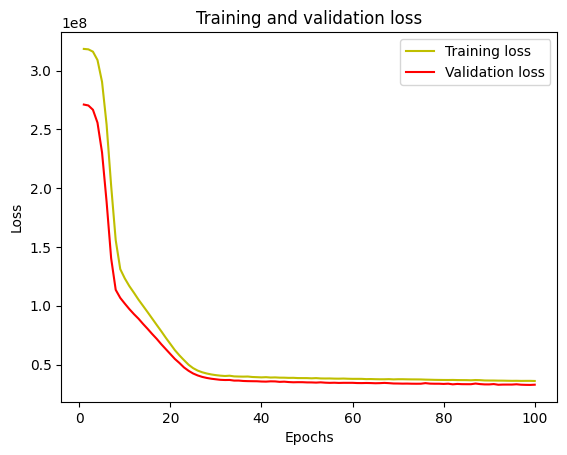

In [60]:
# Evaluate the model:

#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

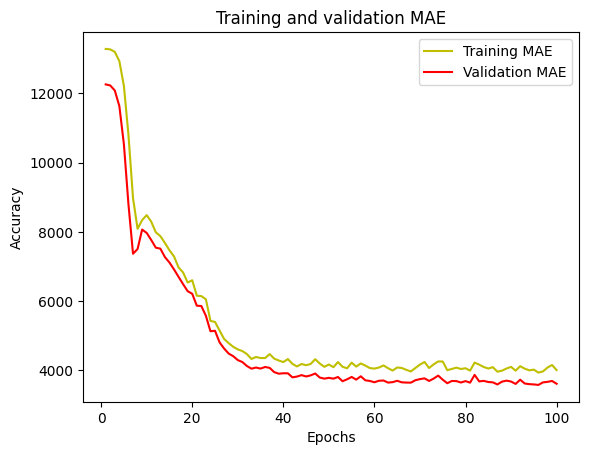

In [61]:
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From looking at our plots, we can see that the validation data error is lower albeit not by much when compared to the training loss.
This suggets that that model may be overfitting and we will have to look at some hyperparameter tuning to avoid overfitting. 

Lets see how our base model performs on the test data. 

### Make predictions

In [62]:
# predictions on test data:
base_predictions = base_model.predict(X_test[:5].values)
print("Predicted values are: ", base_predictions)
print("Real values are: ", y_test[:5].values)


1/1 [==============================] - 0s 27ms/step
Predicted values are:  [[ 8031.685 ]
 [ 6371.5215]
 [12996.241 ]
 [29807.477 ]
 [ 7891.6553]]
Real values are:  [[ 8688.85885]
 [ 5708.867  ]
 [11436.73815]
 [38746.3551 ]
 [ 4463.2051 ]]


### Evaluate the model on the test sets:

In [91]:
mse_neural, mae_neural = base_model.evaluate(X_test, y_test)
print('Mean squared error from neural net: ', mse_neural)
print('Mean absolute error from neural net: ', mae_neural)

9/9 [==============================] - 0s 2ms/step - loss: 34735292.0000 - mae: 3949.4141
Mean squared error from neural net:  34735292.0
Mean absolute error from neural net:  3949.4140625


The mean absolute error calculates the absolute difference between the predicted values and the target values and is more easier to understand compared to the Mean squared error. 

The mean squared error is easier because it is in the same unit as our target variable while the mean squared error is as the name suggests a squared value of the average error between 
the predicted valus and the real values. It is also sensitive to outliers.

mae represents the avaerage absolute error between our predictions and the actual values or the real values from our data set.


Lets use the keras regressor from scikeras and gridsearch to find the best hyper parameters. Lets also look at the parameters that are available through the keras regressor:


In [64]:
keras_regressor = KerasRegressor(build_fn=base_model, verbose=1, random_state=42)

# determining a range of values for hyperparameter tuning


In [65]:
keras_regressor.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])

In [66]:
# Looks like we can only determine the optimizer, batch_size, number of epochs using the keras regressor. 
# We can use keras tuner to determine the number of layers, number of neurons to help find the optimal number of hyperparametsrs

# Defining the parameters for our grid search using the keras regressor.
params = {
    
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'sgd'],
    'epochs': [100, 200, 300],
}

In [67]:
grid_search = GridSearchCV(estimator=keras_regressor, param_grid=params, cv=3)

In [69]:
grid_search.fit(X_train, y_train)

INFO:tensorflow:Assets written to: ram://46f52ee0b0224903802b6e7894abd570/assets


INFO:tensorflow:Assets written to: ram://46f52ee0b0224903802b6e7894abd570/assets
2023-11-21 13:53:22.637889: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://09f1770e20654d689706ad9ca417e340: INVALID_ARGUMENT: ram://09f1770e20654d689706ad9ca417e340 is a directory.


INFO:tensorflow:Assets written to: ram://61e80e783b064db3bda958406599b0c1/assets


INFO:tensorflow:Assets written to: ram://61e80e783b064db3bda958406599b0c1/assets


Epoch 1/100


2023-11-21 13:53:22.906110: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://a9547cba8d28464fa0e16a188192a934: INVALID_ARGUMENT: ram://a9547cba8d28464fa0e16a188192a934 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 37517572.0000 - mae: 4155.3560
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 37477328.0000 - mae: 4180.0186
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 37456152.0000 - mae: 4201.7612
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 37336968.0000 - mae: 4194.2158
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 37616124.0000 - mae: 4148.5479
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 37307208.0000 - mae: 4211.8037
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 37238472.0000 - mae: 4215.3418
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 37128576.0000 - mae: 4192.2949
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 37103512.0000 - mae: 4236.1768
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 37

INFO:tensorflow:Assets written to: ram://a0911a023b4d40829872ccdcf57c1909/assets


Epoch 1/100


2023-11-21 13:53:27.510715: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://c1b6a1d9a1274ca1a205accca2ae3117: INVALID_ARGUMENT: ram://c1b6a1d9a1274ca1a205accca2ae3117 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 34836904.0000 - mae: 3915.4668
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 34719924.0000 - mae: 3936.9583
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 34578400.0000 - mae: 3896.5518
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 34497052.0000 - mae: 3870.4487
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 34547140.0000 - mae: 3826.0352
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 34519988.0000 - mae: 3863.1685
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 34399444.0000 - mae: 3830.1965
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 34284124.0000 - mae: 3810.7263
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 34261308.0000 - mae: 3822.3022
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://318384d84ca346b3804f00d619586c9e/assets


INFO:tensorflow:Assets written to: ram://318384d84ca346b3804f00d619586c9e/assets


Epoch 1/100


2023-11-21 13:53:32.334142: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://8a3ee99f6a074f428a5fa3988ead64a6: INVALID_ARGUMENT: ram://8a3ee99f6a074f428a5fa3988ead64a6 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 35181056.0000 - mae: 3924.5439
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 35141180.0000 - mae: 3911.9268
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 35081164.0000 - mae: 3892.1096
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 35051612.0000 - mae: 3871.8423
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 34951136.0000 - mae: 3891.2219
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 34968408.0000 - mae: 3902.9150
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 34897064.0000 - mae: 3909.8479
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 34850188.0000 - mae: 3908.6255
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 34784500.0000 - mae: 3881.2798
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://212b8cb3cdc94ba4b4f00ead00fac841/assets


Epoch 1/100


2023-11-21 13:53:36.931203: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://a525827290a3448fb519a26a3758ac1c: INVALID_ARGUMENT: ram://a525827290a3448fb519a26a3758ac1c is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 37517572.0000 - mae: 4155.3560
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 37477328.0000 - mae: 4180.0186
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 37456152.0000 - mae: 4201.7612
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 37336968.0000 - mae: 4194.2158
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 37616124.0000 - mae: 4148.5479
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 37307208.0000 - mae: 4211.8037
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 37238472.0000 - mae: 4215.3418
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 37128576.0000 - mae: 4192.2949
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 37103512.0000 - mae: 4236.1768
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 37

INFO:tensorflow:Assets written to: ram://d53f02c13ba54f8f9e2e1be6984104b9/assets


Epoch 1/100


2023-11-21 13:53:41.515760: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://89b6211c24454f648c1b6fe3474c208c: INVALID_ARGUMENT: ram://89b6211c24454f648c1b6fe3474c208c is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 34836904.0000 - mae: 3915.4668
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 34719924.0000 - mae: 3936.9583
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 34578400.0000 - mae: 3896.5518
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 34497052.0000 - mae: 3870.4487
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 34547140.0000 - mae: 3826.0352
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 34519988.0000 - mae: 3863.1685
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 34399444.0000 - mae: 3830.1965
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 34284124.0000 - mae: 3810.7263
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 34261308.0000 - mae: 3822.3022
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://d11b845b6746463ab9933fbd7f2c1d41/assets


Epoch 1/100


2023-11-21 13:53:46.162130: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://53cd36c3df864ed4846163aeae7d9517: INVALID_ARGUMENT: ram://53cd36c3df864ed4846163aeae7d9517 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 35181056.0000 - mae: 3924.5439
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 35141180.0000 - mae: 3911.9268
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 35081164.0000 - mae: 3892.1096
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 35051612.0000 - mae: 3871.8423
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 34951136.0000 - mae: 3891.2219
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 34968408.0000 - mae: 3902.9150
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 34897064.0000 - mae: 3909.8479
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 34850188.0000 - mae: 3908.6255
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 34784500.0000 - mae: 3881.2798
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://0e05e6799c5449d7abaef6020b42ac8c/assets


Epoch 1/200


2023-11-21 13:53:50.697900: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://94ba583f1d064c54b17f4f44389f0356: INVALID_ARGUMENT: ram://94ba583f1d064c54b17f4f44389f0356 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 2ms/step - loss: 37517572.0000 - mae: 4155.3560
Epoch 2/200
17/17 [==============================] - 0s 2ms/step - loss: 37477328.0000 - mae: 4180.0186
Epoch 3/200
17/17 [==============================] - 0s 2ms/step - loss: 37456152.0000 - mae: 4201.7612
Epoch 4/200
17/17 [==============================] - 0s 2ms/step - loss: 37336968.0000 - mae: 4194.2158
Epoch 5/200
17/17 [==============================] - 0s 2ms/step - loss: 37616124.0000 - mae: 4148.5479
Epoch 6/200
17/17 [==============================] - 0s 2ms/step - loss: 37307208.0000 - mae: 4211.8037
Epoch 7/200
17/17 [==============================] - 0s 2ms/step - loss: 37238472.0000 - mae: 4215.3418
Epoch 8/200
17/17 [==============================] - 0s 2ms/step - loss: 37128576.0000 - mae: 4192.2949
Epoch 9/200
17/17 [==============================] - 0s 2ms/step - loss: 37103512.0000 - mae: 4236.1768
Epoch 10/200
17/17 [==============================] - 0s 2ms/step - loss: 37

INFO:tensorflow:Assets written to: ram://d8a52e2e074b4317842c0dc5eba6a7d7/assets


Epoch 1/200


2023-11-21 13:53:58.962197: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://cd7b1aaf1df7416c929d1acf6a184fe3: INVALID_ARGUMENT: ram://cd7b1aaf1df7416c929d1acf6a184fe3 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 34836904.0000 - mae: 3915.4668
Epoch 2/200
17/17 [==============================] - 0s 3ms/step - loss: 34719924.0000 - mae: 3936.9583
Epoch 3/200
17/17 [==============================] - 0s 2ms/step - loss: 34578400.0000 - mae: 3896.5518
Epoch 4/200
17/17 [==============================] - 0s 2ms/step - loss: 34497052.0000 - mae: 3870.4487
Epoch 5/200
17/17 [==============================] - 0s 2ms/step - loss: 34547140.0000 - mae: 3826.0352
Epoch 6/200
17/17 [==============================] - 0s 2ms/step - loss: 34519988.0000 - mae: 3863.1685
Epoch 7/200
17/17 [==============================] - 0s 2ms/step - loss: 34399444.0000 - mae: 3830.1965
Epoch 8/200
17/17 [==============================] - 0s 2ms/step - loss: 34284124.0000 - mae: 3810.7263
Epoch 9/200
17/17 [==============================] - 0s 2ms/step - loss: 34261308.0000 - mae: 3822.3022
Epoch 10/200
17/17 [==============================] - 0s 2ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://44748cadf27548738d3fa2d9bf10f3fe/assets


Epoch 1/200


2023-11-21 13:54:07.166458: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://ef547ff500f846e58d8248ff2238c126: INVALID_ARGUMENT: ram://ef547ff500f846e58d8248ff2238c126 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 35181056.0000 - mae: 3924.5439
Epoch 2/200
17/17 [==============================] - 0s 2ms/step - loss: 35141180.0000 - mae: 3911.9268
Epoch 3/200
17/17 [==============================] - 0s 2ms/step - loss: 35081164.0000 - mae: 3892.1096
Epoch 4/200
17/17 [==============================] - 0s 2ms/step - loss: 35051612.0000 - mae: 3871.8423
Epoch 5/200
17/17 [==============================] - 0s 2ms/step - loss: 34951136.0000 - mae: 3891.2219
Epoch 6/200
17/17 [==============================] - 0s 2ms/step - loss: 34968408.0000 - mae: 3902.9150
Epoch 7/200
17/17 [==============================] - 0s 2ms/step - loss: 34897064.0000 - mae: 3909.8479
Epoch 8/200
17/17 [==============================] - 0s 2ms/step - loss: 34850188.0000 - mae: 3908.6255
Epoch 9/200
17/17 [==============================] - 0s 2ms/step - loss: 34784500.0000 - mae: 3881.2798
Epoch 10/200
17/17 [==============================] - 0s 2ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://024e2e115a714649964985df04a5bb67/assets


Epoch 1/200


2023-11-21 13:54:15.228886: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://93a21a577e7f4658916cc53ea3bec4a8: INVALID_ARGUMENT: ram://93a21a577e7f4658916cc53ea3bec4a8 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 1s 3ms/step - loss: 37517572.0000 - mae: 4155.3560
Epoch 2/200
17/17 [==============================] - 0s 3ms/step - loss: 37477328.0000 - mae: 4180.0186
Epoch 3/200
17/17 [==============================] - 0s 2ms/step - loss: 37456152.0000 - mae: 4201.7612
Epoch 4/200
17/17 [==============================] - 0s 2ms/step - loss: 37336968.0000 - mae: 4194.2158
Epoch 5/200
17/17 [==============================] - 0s 3ms/step - loss: 37616124.0000 - mae: 4148.5479
Epoch 6/200
17/17 [==============================] - 0s 2ms/step - loss: 37307208.0000 - mae: 4211.8037
Epoch 7/200
17/17 [==============================] - 0s 2ms/step - loss: 37238472.0000 - mae: 4215.3418
Epoch 8/200
17/17 [==============================] - 0s 3ms/step - loss: 37128576.0000 - mae: 4192.2949
Epoch 9/200
17/17 [==============================] - 0s 3ms/step - loss: 37103512.0000 - mae: 4236.1768
Epoch 10/200
17/17 [==============================] - 0s 2ms/step - loss: 37

INFO:tensorflow:Assets written to: ram://5105b091e5f24d9d88223b00492bb33c/assets


Epoch 1/200


2023-11-21 13:54:23.810506: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://57649c5e1d394ada94118334db7b7083: INVALID_ARGUMENT: ram://57649c5e1d394ada94118334db7b7083 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 34836904.0000 - mae: 3915.4668
Epoch 2/200
17/17 [==============================] - 0s 2ms/step - loss: 34719924.0000 - mae: 3936.9583
Epoch 3/200
17/17 [==============================] - 0s 2ms/step - loss: 34578400.0000 - mae: 3896.5518
Epoch 4/200
17/17 [==============================] - 0s 2ms/step - loss: 34497052.0000 - mae: 3870.4487
Epoch 5/200
17/17 [==============================] - 0s 3ms/step - loss: 34547140.0000 - mae: 3826.0352
Epoch 6/200
17/17 [==============================] - 0s 2ms/step - loss: 34519988.0000 - mae: 3863.1685
Epoch 7/200
17/17 [==============================] - 0s 2ms/step - loss: 34399444.0000 - mae: 3830.1965
Epoch 8/200
17/17 [==============================] - 0s 2ms/step - loss: 34284124.0000 - mae: 3810.7263
Epoch 9/200
17/17 [==============================] - 0s 2ms/step - loss: 34261308.0000 - mae: 3822.3022
Epoch 10/200
17/17 [==============================] - 0s 2ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://a6bf29831deb4e519cf1805605ef2ecd/assets


Epoch 1/200


2023-11-21 13:54:32.269417: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://62c6f39db02a41c0a18fc009bd30b6db: INVALID_ARGUMENT: ram://62c6f39db02a41c0a18fc009bd30b6db is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 35181056.0000 - mae: 3924.5439
Epoch 2/200
17/17 [==============================] - 0s 2ms/step - loss: 35141180.0000 - mae: 3911.9268
Epoch 3/200
17/17 [==============================] - 0s 2ms/step - loss: 35081164.0000 - mae: 3892.1096
Epoch 4/200
17/17 [==============================] - 0s 2ms/step - loss: 35051612.0000 - mae: 3871.8423
Epoch 5/200
17/17 [==============================] - 0s 2ms/step - loss: 34951136.0000 - mae: 3891.2219
Epoch 6/200
17/17 [==============================] - 0s 2ms/step - loss: 34968408.0000 - mae: 3902.9150
Epoch 7/200
17/17 [==============================] - 0s 2ms/step - loss: 34897064.0000 - mae: 3909.8479
Epoch 8/200
17/17 [==============================] - 0s 2ms/step - loss: 34850188.0000 - mae: 3908.6255
Epoch 9/200
17/17 [==============================] - 0s 2ms/step - loss: 34784500.0000 - mae: 3881.2798
Epoch 10/200
17/17 [==============================] - 0s 2ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://e7633734ee6e41f1b76a700628a4d467/assets


Epoch 1/300


2023-11-21 13:54:40.583805: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://4a0245d8e9d346dcad176c59e52d6ffd: INVALID_ARGUMENT: ram://4a0245d8e9d346dcad176c59e52d6ffd is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 37517572.0000 - mae: 4155.3560
Epoch 2/300
17/17 [==============================] - 0s 2ms/step - loss: 37477328.0000 - mae: 4180.0186
Epoch 3/300
17/17 [==============================] - 0s 2ms/step - loss: 37456152.0000 - mae: 4201.7612
Epoch 4/300
17/17 [==============================] - 0s 2ms/step - loss: 37336968.0000 - mae: 4194.2158
Epoch 5/300
17/17 [==============================] - 0s 2ms/step - loss: 37616124.0000 - mae: 4148.5479
Epoch 6/300
17/17 [==============================] - 0s 2ms/step - loss: 37307208.0000 - mae: 4211.8037
Epoch 7/300
17/17 [==============================] - 0s 2ms/step - loss: 37238472.0000 - mae: 4215.3418
Epoch 8/300
17/17 [==============================] - 0s 2ms/step - loss: 37128576.0000 - mae: 4192.2949
Epoch 9/300
17/17 [==============================] - 0s 2ms/step - loss: 37103512.0000 - mae: 4236.1768
Epoch 10/300
17/17 [==============================] - 0s 2ms/step - loss: 37

INFO:tensorflow:Assets written to: ram://4f16c14ac95d4a3eaca93ad27c33d8da/assets


Epoch 1/300


2023-11-21 13:54:52.664827: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://15097b4945614c849f66150cecd32c73: INVALID_ARGUMENT: ram://15097b4945614c849f66150cecd32c73 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 34836904.0000 - mae: 3915.4668
Epoch 2/300
17/17 [==============================] - 0s 2ms/step - loss: 34719924.0000 - mae: 3936.9583
Epoch 3/300
17/17 [==============================] - 0s 2ms/step - loss: 34578400.0000 - mae: 3896.5518
Epoch 4/300
17/17 [==============================] - 0s 2ms/step - loss: 34497052.0000 - mae: 3870.4487
Epoch 5/300
17/17 [==============================] - 0s 2ms/step - loss: 34547140.0000 - mae: 3826.0352
Epoch 6/300
17/17 [==============================] - 0s 2ms/step - loss: 34519988.0000 - mae: 3863.1685
Epoch 7/300
17/17 [==============================] - 0s 2ms/step - loss: 34399444.0000 - mae: 3830.1965
Epoch 8/300
17/17 [==============================] - 0s 2ms/step - loss: 34284124.0000 - mae: 3810.7263
Epoch 9/300
17/17 [==============================] - 0s 2ms/step - loss: 34261308.0000 - mae: 3822.3022
Epoch 10/300
17/17 [==============================] - 0s 3ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://2914f27bf2a84aad9641a918d0b9f3d0/assets


Epoch 1/300


2023-11-21 13:55:05.360061: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://2a68c57f29844254a8aed7f259b9b8c7: INVALID_ARGUMENT: ram://2a68c57f29844254a8aed7f259b9b8c7 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 2ms/step - loss: 35181056.0000 - mae: 3924.5439
Epoch 2/300
17/17 [==============================] - 0s 3ms/step - loss: 35141180.0000 - mae: 3911.9268
Epoch 3/300
17/17 [==============================] - 0s 3ms/step - loss: 35081164.0000 - mae: 3892.1096
Epoch 4/300
17/17 [==============================] - 0s 3ms/step - loss: 35051612.0000 - mae: 3871.8423
Epoch 5/300
17/17 [==============================] - 0s 3ms/step - loss: 34951136.0000 - mae: 3891.2219
Epoch 6/300
17/17 [==============================] - 0s 3ms/step - loss: 34968408.0000 - mae: 3902.9150
Epoch 7/300
17/17 [==============================] - 0s 3ms/step - loss: 34897064.0000 - mae: 3909.8479
Epoch 8/300
17/17 [==============================] - 0s 3ms/step - loss: 34850188.0000 - mae: 3908.6255
Epoch 9/300
17/17 [==============================] - 0s 3ms/step - loss: 34784500.0000 - mae: 3881.2798
Epoch 10/300
17/17 [==============================] - 0s 3ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://39ca6b74c6be4bfcac5898de117fa88c/assets


Epoch 1/300


2023-11-21 13:55:18.152664: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://24960e3cce9d419999b39631e1adc850: INVALID_ARGUMENT: ram://24960e3cce9d419999b39631e1adc850 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 2ms/step - loss: 37517572.0000 - mae: 4155.3560
Epoch 2/300
17/17 [==============================] - 0s 2ms/step - loss: 37477328.0000 - mae: 4180.0186
Epoch 3/300
17/17 [==============================] - 0s 2ms/step - loss: 37456152.0000 - mae: 4201.7612
Epoch 4/300
17/17 [==============================] - 0s 2ms/step - loss: 37336968.0000 - mae: 4194.2158
Epoch 5/300
17/17 [==============================] - 0s 2ms/step - loss: 37616124.0000 - mae: 4148.5479
Epoch 6/300
17/17 [==============================] - 0s 2ms/step - loss: 37307208.0000 - mae: 4211.8037
Epoch 7/300
17/17 [==============================] - 0s 2ms/step - loss: 37238472.0000 - mae: 4215.3418
Epoch 8/300
17/17 [==============================] - 0s 2ms/step - loss: 37128576.0000 - mae: 4192.2949
Epoch 9/300
17/17 [==============================] - 0s 2ms/step - loss: 37103512.0000 - mae: 4236.1768
Epoch 10/300
17/17 [==============================] - 0s 2ms/step - loss: 37

INFO:tensorflow:Assets written to: ram://9a8cc644d58340d18e8bc2ffef7a1fb2/assets


Epoch 1/300


2023-11-21 13:55:30.287783: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://e8ad3ec88aad430a9a2369b92bc8a48e: INVALID_ARGUMENT: ram://e8ad3ec88aad430a9a2369b92bc8a48e is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 3ms/step - loss: 34836904.0000 - mae: 3915.4668
Epoch 2/300
17/17 [==============================] - 0s 2ms/step - loss: 34719924.0000 - mae: 3936.9583
Epoch 3/300
17/17 [==============================] - 0s 2ms/step - loss: 34578400.0000 - mae: 3896.5518
Epoch 4/300
17/17 [==============================] - 0s 3ms/step - loss: 34497052.0000 - mae: 3870.4487
Epoch 5/300
17/17 [==============================] - 0s 3ms/step - loss: 34547140.0000 - mae: 3826.0352
Epoch 6/300
17/17 [==============================] - 0s 3ms/step - loss: 34519988.0000 - mae: 3863.1685
Epoch 7/300
17/17 [==============================] - 0s 3ms/step - loss: 34399444.0000 - mae: 3830.1965
Epoch 8/300
17/17 [==============================] - 0s 2ms/step - loss: 34284124.0000 - mae: 3810.7263
Epoch 9/300
17/17 [==============================] - 0s 3ms/step - loss: 34261308.0000 - mae: 3822.3022
Epoch 10/300
17/17 [==============================] - 0s 2ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://1d5dea1c325d4c4aa8b7b001d2eb86c6/assets


Epoch 1/300


2023-11-21 13:55:42.554314: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://4503117f5fff4fb3a62b400b5644ded6: INVALID_ARGUMENT: ram://4503117f5fff4fb3a62b400b5644ded6 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 1s 3ms/step - loss: 35181056.0000 - mae: 3924.5439
Epoch 2/300
17/17 [==============================] - 0s 3ms/step - loss: 35141180.0000 - mae: 3911.9268
Epoch 3/300
17/17 [==============================] - 0s 3ms/step - loss: 35081164.0000 - mae: 3892.1096
Epoch 4/300
17/17 [==============================] - 0s 3ms/step - loss: 35051612.0000 - mae: 3871.8423
Epoch 5/300
17/17 [==============================] - 0s 2ms/step - loss: 34951136.0000 - mae: 3891.2219
Epoch 6/300
17/17 [==============================] - 0s 3ms/step - loss: 34968408.0000 - mae: 3902.9150
Epoch 7/300
17/17 [==============================] - 0s 2ms/step - loss: 34897064.0000 - mae: 3909.8479
Epoch 8/300
17/17 [==============================] - 0s 2ms/step - loss: 34850188.0000 - mae: 3908.6255
Epoch 9/300
17/17 [==============================] - 0s 3ms/step - loss: 34784500.0000 - mae: 3881.2798
Epoch 10/300
17/17 [==============================] - 0s 2ms/step - loss: 34

INFO:tensorflow:Assets written to: ram://75be2be384ef41cea6b347982d19d6d0/assets


Epoch 1/100


2023-11-21 13:55:54.738925: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://000500af6a234aeabcc43e1149a7c504: INVALID_ARGUMENT: ram://000500af6a234aeabcc43e1149a7c504 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 37506996.0000 - mae: 4147.9634
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 37490928.0000 - mae: 4160.9321
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 37477772.0000 - mae: 4175.9829
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 37417884.0000 - mae: 4176.2485
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 37504676.0000 - mae: 4158.1421
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 37370884.0000 - mae: 4152.3921
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 37325716.0000 - mae: 4161.7832
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 37288892.0000 - mae: 4165.7603
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 37276864.0000 - mae: 4197.5483
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 37227860.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://2eae827267ee43738e2222d9745f95c1/assets


Epoch 1/100


2023-11-21 13:55:57.738692: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://9cf25e14d84845f187b5878201d42c99: INVALID_ARGUMENT: ram://9cf25e14d84845f187b5878201d42c99 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 34846016.0000 - mae: 3912.5881
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 34776604.0000 - mae: 3925.9229
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 34684476.0000 - mae: 3918.8413
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 34627136.0000 - mae: 3902.3770
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 34621700.0000 - mae: 3880.9277
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 34578032.0000 - mae: 3879.4116
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 34493948.0000 - mae: 3880.3613
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 34453716.0000 - mae: 3875.0205
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 34425092.0000 - mae: 3864.8132
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 34377272.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://cfb0ce3c2866484dbf20c3d914d7aa25/assets


Epoch 1/100


2023-11-21 13:56:00.691137: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://7d5224d0e6a44d458308afdd9f251115: INVALID_ARGUMENT: ram://7d5224d0e6a44d458308afdd9f251115 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 35159144.0000 - mae: 3932.5637
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 35146924.0000 - mae: 3929.0510
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 35118056.0000 - mae: 3910.5310
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 35098192.0000 - mae: 3888.4343
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 35045168.0000 - mae: 3887.0369
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 35027792.0000 - mae: 3895.3030
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 35004500.0000 - mae: 3912.1960
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 34977220.0000 - mae: 3921.7061
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 34942416.0000 - mae: 3908.1748
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 34939660.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://9358249de2b34b958c830184e57ce803/assets


Epoch 1/100


2023-11-21 13:56:03.665217: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://5f5f6b417f634bccba9f6dac703e3976: INVALID_ARGUMENT: ram://5f5f6b417f634bccba9f6dac703e3976 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 37506996.0000 - mae: 4147.9634
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 37490928.0000 - mae: 4160.9321
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 37477772.0000 - mae: 4175.9829
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 37417884.0000 - mae: 4176.2485
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 37504676.0000 - mae: 4158.1421
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 37370884.0000 - mae: 4152.3921
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 37325716.0000 - mae: 4161.7832
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 37288892.0000 - mae: 4165.7603
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 37276864.0000 - mae: 4197.5483
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - loss: 37227860.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://49f08ca950a14a7fa6df32efe15b794f/assets


Epoch 1/100


2023-11-21 13:56:06.665195: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://308b727c92f243968acad613e9660e7f: INVALID_ARGUMENT: ram://308b727c92f243968acad613e9660e7f is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 34846016.0000 - mae: 3912.5881
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 34776604.0000 - mae: 3925.9229
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 34684476.0000 - mae: 3918.8413
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 34627136.0000 - mae: 3902.3770
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 34621700.0000 - mae: 3880.9277
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 34578032.0000 - mae: 3879.4116
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 34493948.0000 - mae: 3880.3613
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 34453716.0000 - mae: 3875.0205
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 34425092.0000 - mae: 3864.8132
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 34377272.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://97856790b5e84e2c835cb3456837c2c5/assets


Epoch 1/100


2023-11-21 13:56:09.754509: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://bcbcae622e5d45d6b0a57750efe529be: INVALID_ARGUMENT: ram://bcbcae622e5d45d6b0a57750efe529be is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 2ms/step - loss: 35159144.0000 - mae: 3932.5637
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 35146924.0000 - mae: 3929.0510
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 35118056.0000 - mae: 3910.5310
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 35098192.0000 - mae: 3888.4343
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 35045168.0000 - mae: 3887.0369
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 35027792.0000 - mae: 3895.3030
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 35004500.0000 - mae: 3912.1960
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 34977220.0000 - mae: 3921.7061
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 34942416.0000 - mae: 3908.1748
Epoch 10/100
9/9 [==============================] - 0s 3ms/step - loss: 34939660.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://a2e0c23c4e914767b0edc650e1756913/assets


Epoch 1/200


2023-11-21 13:56:12.938929: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://4a40bc795441403a91108e11af960946: INVALID_ARGUMENT: ram://4a40bc795441403a91108e11af960946 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 37506996.0000 - mae: 4147.9634
Epoch 2/200
9/9 [==============================] - 0s 2ms/step - loss: 37490928.0000 - mae: 4160.9321
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 37477772.0000 - mae: 4175.9829
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 37417884.0000 - mae: 4176.2485
Epoch 5/200
9/9 [==============================] - 0s 2ms/step - loss: 37504676.0000 - mae: 4158.1421
Epoch 6/200
9/9 [==============================] - 0s 2ms/step - loss: 37370884.0000 - mae: 4152.3921
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 37325716.0000 - mae: 4161.7832
Epoch 8/200
9/9 [==============================] - 0s 2ms/step - loss: 37288892.0000 - mae: 4165.7603
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 37276864.0000 - mae: 4197.5483
Epoch 10/200
9/9 [==============================] - 0s 3ms/step - loss: 37227860.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://8062e343b4b449c7b9969f292b86db11/assets


Epoch 1/200


2023-11-21 13:56:18.239385: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://c9bb37207d2448bd8922ddba85950ca3: INVALID_ARGUMENT: ram://c9bb37207d2448bd8922ddba85950ca3 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 34846016.0000 - mae: 3912.5881
Epoch 2/200
9/9 [==============================] - 0s 2ms/step - loss: 34776604.0000 - mae: 3925.9229
Epoch 3/200
9/9 [==============================] - 0s 2ms/step - loss: 34684476.0000 - mae: 3918.8413
Epoch 4/200
9/9 [==============================] - 0s 2ms/step - loss: 34627136.0000 - mae: 3902.3770
Epoch 5/200
9/9 [==============================] - 0s 2ms/step - loss: 34621700.0000 - mae: 3880.9277
Epoch 6/200
9/9 [==============================] - 0s 2ms/step - loss: 34578032.0000 - mae: 3879.4116
Epoch 7/200
9/9 [==============================] - 0s 2ms/step - loss: 34493948.0000 - mae: 3880.3613
Epoch 8/200
9/9 [==============================] - 0s 3ms/step - loss: 34453716.0000 - mae: 3875.0205
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 34425092.0000 - mae: 3864.8132
Epoch 10/200
9/9 [==============================] - 0s 3ms/step - loss: 34377272.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://ff3b444d63294437a9b2559fac9d8a72/assets


INFO:tensorflow:Assets written to: ram://ff3b444d63294437a9b2559fac9d8a72/assets


Epoch 1/200


2023-11-21 13:56:23.936728: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://1e427bd1a49f40dcaf9661e3690c699c: INVALID_ARGUMENT: ram://1e427bd1a49f40dcaf9661e3690c699c is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 35159144.0000 - mae: 3932.5637
Epoch 2/200
9/9 [==============================] - 0s 3ms/step - loss: 35146924.0000 - mae: 3929.0510
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 35118056.0000 - mae: 3910.5310
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 35098192.0000 - mae: 3888.4343
Epoch 5/200
9/9 [==============================] - 0s 3ms/step - loss: 35045168.0000 - mae: 3887.0369
Epoch 6/200
9/9 [==============================] - 0s 3ms/step - loss: 35027792.0000 - mae: 3895.3030
Epoch 7/200
9/9 [==============================] - 0s 2ms/step - loss: 35004500.0000 - mae: 3912.1960
Epoch 8/200
9/9 [==============================] - 0s 2ms/step - loss: 34977220.0000 - mae: 3921.7061
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 34942416.0000 - mae: 3908.1748
Epoch 10/200
9/9 [==============================] - 0s 2ms/step - loss: 34939660.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://6a03d69d19474690b19bd029689f10af/assets


Epoch 1/200


2023-11-21 13:56:29.417131: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://f0bb001741724515b77af727b4206c69: INVALID_ARGUMENT: ram://f0bb001741724515b77af727b4206c69 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 37506996.0000 - mae: 4147.9634
Epoch 2/200
9/9 [==============================] - 0s 3ms/step - loss: 37490928.0000 - mae: 4160.9321
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 37477772.0000 - mae: 4175.9829
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 37417884.0000 - mae: 4176.2485
Epoch 5/200
9/9 [==============================] - 0s 3ms/step - loss: 37504676.0000 - mae: 4158.1421
Epoch 6/200
9/9 [==============================] - 0s 3ms/step - loss: 37370884.0000 - mae: 4152.3921
Epoch 7/200
9/9 [==============================] - 0s 2ms/step - loss: 37325716.0000 - mae: 4161.7832
Epoch 8/200
9/9 [==============================] - 0s 3ms/step - loss: 37288892.0000 - mae: 4165.7603
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 37276864.0000 - mae: 4197.5483
Epoch 10/200
9/9 [==============================] - 0s 2ms/step - loss: 37227860.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://18875685af384e13b01055fcc08112c8/assets


Epoch 1/200


2023-11-21 13:56:35.023125: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://90c65065d7d941c496cb795e68cbb5a1: INVALID_ARGUMENT: ram://90c65065d7d941c496cb795e68cbb5a1 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 34846016.0000 - mae: 3912.5881
Epoch 2/200
9/9 [==============================] - 0s 3ms/step - loss: 34776604.0000 - mae: 3925.9229
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 34684476.0000 - mae: 3918.8413
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 34627136.0000 - mae: 3902.3770
Epoch 5/200
9/9 [==============================] - 0s 3ms/step - loss: 34621700.0000 - mae: 3880.9277
Epoch 6/200
9/9 [==============================] - 0s 2ms/step - loss: 34578032.0000 - mae: 3879.4116
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 34493948.0000 - mae: 3880.3613
Epoch 8/200
9/9 [==============================] - 0s 4ms/step - loss: 34453716.0000 - mae: 3875.0205
Epoch 9/200
9/9 [==============================] - 0s 3ms/step - loss: 34425092.0000 - mae: 3864.8132
Epoch 10/200
9/9 [==============================] - 0s 3ms/step - loss: 34377272.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://9cd483aab078490ea24555100fa578ea/assets


Epoch 1/200


2023-11-21 13:56:40.655351: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://86206c9abd114b43b107b725d03ebae8: INVALID_ARGUMENT: ram://86206c9abd114b43b107b725d03ebae8 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 35159144.0000 - mae: 3932.5637
Epoch 2/200
9/9 [==============================] - 0s 3ms/step - loss: 35146924.0000 - mae: 3929.0510
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 35118056.0000 - mae: 3910.5310
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 35098192.0000 - mae: 3888.4343
Epoch 5/200
9/9 [==============================] - 0s 2ms/step - loss: 35045168.0000 - mae: 3887.0369
Epoch 6/200
9/9 [==============================] - 0s 2ms/step - loss: 35027792.0000 - mae: 3895.3030
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 35004500.0000 - mae: 3912.1960
Epoch 8/200
9/9 [==============================] - 0s 3ms/step - loss: 34977220.0000 - mae: 3921.7061
Epoch 9/200
9/9 [==============================] - 0s 3ms/step - loss: 34942416.0000 - mae: 3908.1748
Epoch 10/200
9/9 [==============================] - 0s 3ms/step - loss: 34939660.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://9c6d31412879496b9ee343819babb6a8/assets


Epoch 1/300


2023-11-21 13:56:46.316886: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://5107d882c16443178f26be2a88c09a58: INVALID_ARGUMENT: ram://5107d882c16443178f26be2a88c09a58 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 37506996.0000 - mae: 4147.9634
Epoch 2/300
9/9 [==============================] - 0s 2ms/step - loss: 37490928.0000 - mae: 4160.9321
Epoch 3/300
9/9 [==============================] - 0s 4ms/step - loss: 37477772.0000 - mae: 4175.9829
Epoch 4/300
9/9 [==============================] - 0s 3ms/step - loss: 37417884.0000 - mae: 4176.2485
Epoch 5/300
9/9 [==============================] - 0s 3ms/step - loss: 37504676.0000 - mae: 4158.1421
Epoch 6/300
9/9 [==============================] - 0s 3ms/step - loss: 37370884.0000 - mae: 4152.3921
Epoch 7/300
9/9 [==============================] - 0s 3ms/step - loss: 37325716.0000 - mae: 4161.7832
Epoch 8/300
9/9 [==============================] - 0s 3ms/step - loss: 37288892.0000 - mae: 4165.7603
Epoch 9/300
9/9 [==============================] - 0s 2ms/step - loss: 37276864.0000 - mae: 4197.5483
Epoch 10/300
9/9 [==============================] - 0s 2ms/step - loss: 37227860.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://619b68fe24624d31bc4f2a49c3e4c02e/assets


Epoch 1/300


2023-11-21 13:56:53.970055: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://cdccad0a12fd4d2b853c82c588fca595: INVALID_ARGUMENT: ram://cdccad0a12fd4d2b853c82c588fca595 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 34846016.0000 - mae: 3912.5881
Epoch 2/300
9/9 [==============================] - 0s 2ms/step - loss: 34776604.0000 - mae: 3925.9229
Epoch 3/300
9/9 [==============================] - 0s 3ms/step - loss: 34684476.0000 - mae: 3918.8413
Epoch 4/300
9/9 [==============================] - 0s 2ms/step - loss: 34627136.0000 - mae: 3902.3770
Epoch 5/300
9/9 [==============================] - 0s 2ms/step - loss: 34621700.0000 - mae: 3880.9277
Epoch 6/300
9/9 [==============================] - 0s 2ms/step - loss: 34578032.0000 - mae: 3879.4116
Epoch 7/300
9/9 [==============================] - 0s 3ms/step - loss: 34493948.0000 - mae: 3880.3613
Epoch 8/300
9/9 [==============================] - 0s 2ms/step - loss: 34453716.0000 - mae: 3875.0205
Epoch 9/300
9/9 [==============================] - 0s 2ms/step - loss: 34425092.0000 - mae: 3864.8132
Epoch 10/300
9/9 [==============================] - 0s 2ms/step - loss: 34377272.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://037cace8d0764e8f95e82100a2756d6a/assets


Epoch 1/300


2023-11-21 13:57:01.365192: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://eb65394b25b7488a91161166ff6b1dc3: INVALID_ARGUMENT: ram://eb65394b25b7488a91161166ff6b1dc3 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 2ms/step - loss: 35159144.0000 - mae: 3932.5637
Epoch 2/300
9/9 [==============================] - 0s 2ms/step - loss: 35146924.0000 - mae: 3929.0510
Epoch 3/300
9/9 [==============================] - 0s 2ms/step - loss: 35118056.0000 - mae: 3910.5310
Epoch 4/300
9/9 [==============================] - 0s 2ms/step - loss: 35098192.0000 - mae: 3888.4343
Epoch 5/300
9/9 [==============================] - 0s 2ms/step - loss: 35045168.0000 - mae: 3887.0369
Epoch 6/300
9/9 [==============================] - 0s 2ms/step - loss: 35027792.0000 - mae: 3895.3030
Epoch 7/300
9/9 [==============================] - 0s 2ms/step - loss: 35004500.0000 - mae: 3912.1960
Epoch 8/300
9/9 [==============================] - 0s 2ms/step - loss: 34977220.0000 - mae: 3921.7061
Epoch 9/300
9/9 [==============================] - 0s 2ms/step - loss: 34942416.0000 - mae: 3908.1748
Epoch 10/300
9/9 [==============================] - 0s 2ms/step - loss: 34939660.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://273264f9aa124a76b90cda4823268ae4/assets


Epoch 1/300


2023-11-21 13:57:08.934584: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://af9fc0333f054f99af72a3f9663c1aba: INVALID_ARGUMENT: ram://af9fc0333f054f99af72a3f9663c1aba is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 37506996.0000 - mae: 4147.9634
Epoch 2/300
9/9 [==============================] - 0s 4ms/step - loss: 37490928.0000 - mae: 4160.9321
Epoch 3/300
9/9 [==============================] - 0s 3ms/step - loss: 37477772.0000 - mae: 4175.9829
Epoch 4/300
9/9 [==============================] - 0s 3ms/step - loss: 37417884.0000 - mae: 4176.2485
Epoch 5/300
9/9 [==============================] - 0s 3ms/step - loss: 37504676.0000 - mae: 4158.1421
Epoch 6/300
9/9 [==============================] - 0s 3ms/step - loss: 37370884.0000 - mae: 4152.3921
Epoch 7/300
9/9 [==============================] - 0s 2ms/step - loss: 37325716.0000 - mae: 4161.7832
Epoch 8/300
9/9 [==============================] - 0s 3ms/step - loss: 37288892.0000 - mae: 4165.7603
Epoch 9/300
9/9 [==============================] - 0s 3ms/step - loss: 37276864.0000 - mae: 4197.5483
Epoch 10/300
9/9 [==============================] - 0s 3ms/step - loss: 37227860.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://166d03906c1a4e52916acdf208fb54d9/assets


INFO:tensorflow:Assets written to: ram://166d03906c1a4e52916acdf208fb54d9/assets


Epoch 1/300


2023-11-21 13:57:17.147826: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://df8e2228efcd466d8beca44f3f55c973: INVALID_ARGUMENT: ram://df8e2228efcd466d8beca44f3f55c973 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 34846016.0000 - mae: 3912.5881
Epoch 2/300
9/9 [==============================] - 0s 3ms/step - loss: 34776604.0000 - mae: 3925.9229
Epoch 3/300
9/9 [==============================] - 0s 2ms/step - loss: 34684476.0000 - mae: 3918.8413
Epoch 4/300
9/9 [==============================] - 0s 3ms/step - loss: 34627136.0000 - mae: 3902.3770
Epoch 5/300
9/9 [==============================] - 0s 3ms/step - loss: 34621700.0000 - mae: 3880.9277
Epoch 6/300
9/9 [==============================] - 0s 3ms/step - loss: 34578032.0000 - mae: 3879.4116
Epoch 7/300
9/9 [==============================] - 0s 2ms/step - loss: 34493948.0000 - mae: 3880.3613
Epoch 8/300
9/9 [==============================] - 0s 2ms/step - loss: 34453716.0000 - mae: 3875.0205
Epoch 9/300
9/9 [==============================] - 0s 3ms/step - loss: 34425092.0000 - mae: 3864.8132
Epoch 10/300
9/9 [==============================] - 0s 2ms/step - loss: 34377272.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://d803d4e6c2204cd18a8fbf3c28b95109/assets


Epoch 1/300


2023-11-21 13:57:24.834138: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://29acf6217b2646a79cda65ccd1001f55: INVALID_ARGUMENT: ram://29acf6217b2646a79cda65ccd1001f55 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 35159144.0000 - mae: 3932.5637
Epoch 2/300
9/9 [==============================] - 0s 3ms/step - loss: 35146924.0000 - mae: 3929.0510
Epoch 3/300
9/9 [==============================] - 0s 3ms/step - loss: 35118056.0000 - mae: 3910.5310
Epoch 4/300
9/9 [==============================] - 0s 2ms/step - loss: 35098192.0000 - mae: 3888.4343
Epoch 5/300
9/9 [==============================] - 0s 4ms/step - loss: 35045168.0000 - mae: 3887.0369
Epoch 6/300
9/9 [==============================] - 0s 3ms/step - loss: 35027792.0000 - mae: 3895.3030
Epoch 7/300
9/9 [==============================] - 0s 2ms/step - loss: 35004500.0000 - mae: 3912.1960
Epoch 8/300
9/9 [==============================] - 0s 3ms/step - loss: 34977220.0000 - mae: 3921.7061
Epoch 9/300
9/9 [==============================] - 0s 3ms/step - loss: 34942416.0000 - mae: 3908.1748
Epoch 10/300
9/9 [==============================] - 0s 4ms/step - loss: 34939660.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://d5f791859d6c47b3882b320bfbeaf52f/assets


Epoch 1/100


2023-11-21 13:57:32.388003: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://1b7a57fd50cc494283f3f6720b1c9aee: INVALID_ARGUMENT: ram://1b7a57fd50cc494283f3f6720b1c9aee is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 4ms/step - loss: 37506972.0000 - mae: 4143.5264
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 37500048.0000 - mae: 4150.1768
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 37495832.0000 - mae: 4158.1343
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 37465376.0000 - mae: 4159.4331
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 37485532.0000 - mae: 4152.1519
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 37434204.0000 - mae: 4143.9648
Epoch 7/100
5/5 [==============================] - 0s 2ms/step - loss: 37419956.0000 - mae: 4140.6670
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 37405072.0000 - mae: 4136.9990
Epoch 9/100
5/5 [==============================] - 0s 2ms/step - loss: 37388232.0000 - mae: 4150.1045
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 37349104.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://82a61fa9c7984cab8399a0e1a13ff2cf/assets


Epoch 1/100


2023-11-21 13:57:34.649115: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://fa8d2e6d32d14bf4ad9b3b10e5ef39a1: INVALID_ARGUMENT: ram://fa8d2e6d32d14bf4ad9b3b10e5ef39a1 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 34863184.0000 - mae: 3910.6604
Epoch 2/100
5/5 [==============================] - 0s 2ms/step - loss: 34818292.0000 - mae: 3916.1890
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 34775112.0000 - mae: 3913.5103
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 34740852.0000 - mae: 3904.8032
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 34717744.0000 - mae: 3895.8879
Epoch 6/100
5/5 [==============================] - 0s 2ms/step - loss: 34687728.0000 - mae: 3894.6953
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 34611684.0000 - mae: 3900.2351
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 34580708.0000 - mae: 3907.7444
Epoch 9/100
5/5 [==============================] - 0s 2ms/step - loss: 34566164.0000 - mae: 3909.7449
Epoch 10/100
5/5 [==============================] - 0s 2ms/step - loss: 34525676.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://2f3dd0c03c1b440397673a85dd63485c/assets


Epoch 1/100


2023-11-21 13:57:36.835627: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://2b806ca5ae284f5a88871d12aa51c8b5: INVALID_ARGUMENT: ram://2b806ca5ae284f5a88871d12aa51c8b5 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 35159268.0000 - mae: 3933.8899
Epoch 2/100
5/5 [==============================] - 0s 2ms/step - loss: 35152524.0000 - mae: 3935.2883
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 35138748.0000 - mae: 3926.4858
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 35124188.0000 - mae: 3913.4985
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 35096580.0000 - mae: 3906.9417
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 35083396.0000 - mae: 3906.3618
Epoch 7/100
5/5 [==============================] - 0s 2ms/step - loss: 35066096.0000 - mae: 3913.1096
Epoch 8/100
5/5 [==============================] - 0s 2ms/step - loss: 35052708.0000 - mae: 3919.9470
Epoch 9/100
5/5 [==============================] - 0s 2ms/step - loss: 35034604.0000 - mae: 3916.3503
Epoch 10/100
5/5 [==============================] - 0s 2ms/step - loss: 35027032.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://4dde3a602c2746e7935e835ef60e5bc5/assets


Epoch 1/100


2023-11-21 13:57:39.032900: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://896fbceb590149fbb390fd79fd1bc9c5: INVALID_ARGUMENT: ram://896fbceb590149fbb390fd79fd1bc9c5 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 4ms/step - loss: 37506972.0000 - mae: 4143.5264
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 37500048.0000 - mae: 4150.1768
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 37495832.0000 - mae: 4158.1343
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 37465376.0000 - mae: 4159.4331
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 37485532.0000 - mae: 4152.1519
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 37434204.0000 - mae: 4143.9648
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 37419956.0000 - mae: 4140.6670
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 37405072.0000 - mae: 4136.9990
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 37388232.0000 - mae: 4150.1045
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 37349104.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://5631b4146b2f42af8f3331d47cf44163/assets


Epoch 1/100


2023-11-21 13:57:41.242952: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://62b3f95d37ef4d57a1e736f8e7efde25: INVALID_ARGUMENT: ram://62b3f95d37ef4d57a1e736f8e7efde25 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 4ms/step - loss: 34863184.0000 - mae: 3910.6604
Epoch 2/100
5/5 [==============================] - 0s 2ms/step - loss: 34818292.0000 - mae: 3916.1890
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 34775112.0000 - mae: 3913.5103
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 34740852.0000 - mae: 3904.8032
Epoch 5/100
5/5 [==============================] - 0s 2ms/step - loss: 34717744.0000 - mae: 3895.8879
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 34687728.0000 - mae: 3894.6953
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 34611684.0000 - mae: 3900.2351
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 34580708.0000 - mae: 3907.7444
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 34566164.0000 - mae: 3909.7449
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 34525676.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://6b0350a9a89a418088bb50ea9634925e/assets


Epoch 1/100


2023-11-21 13:57:43.526227: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://0864c0c3131f4eb8aed2da9fdcb5ed22: INVALID_ARGUMENT: ram://0864c0c3131f4eb8aed2da9fdcb5ed22 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 35159268.0000 - mae: 3933.8899
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 35152524.0000 - mae: 3935.2883
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 35138748.0000 - mae: 3926.4858
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 35124188.0000 - mae: 3913.4985
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 35096580.0000 - mae: 3906.9417
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 35083396.0000 - mae: 3906.3618
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 35066096.0000 - mae: 3913.1096
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 35052708.0000 - mae: 3919.9470
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 35034604.0000 - mae: 3916.3503
Epoch 10/100
5/5 [==============================] - 0s 2ms/step - loss: 35027032.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://68cc483ac9c044b09a1bc65bb0ea371c/assets


Epoch 1/200


2023-11-21 13:57:45.737368: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://8bc148afb0eb42339ec20735114c4ada: INVALID_ARGUMENT: ram://8bc148afb0eb42339ec20735114c4ada is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 37506972.0000 - mae: 4143.5264
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 37500048.0000 - mae: 4150.1768
Epoch 3/200
5/5 [==============================] - 0s 2ms/step - loss: 37495832.0000 - mae: 4158.1343
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 37465376.0000 - mae: 4159.4331
Epoch 5/200
5/5 [==============================] - 0s 2ms/step - loss: 37485532.0000 - mae: 4152.1519
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 37434204.0000 - mae: 4143.9648
Epoch 7/200
5/5 [==============================] - 0s 3ms/step - loss: 37419956.0000 - mae: 4140.6670
Epoch 8/200
5/5 [==============================] - 0s 2ms/step - loss: 37405072.0000 - mae: 4136.9990
Epoch 9/200
5/5 [==============================] - 0s 4ms/step - loss: 37388232.0000 - mae: 4150.1045
Epoch 10/200
5/5 [==============================] - 0s 3ms/step - loss: 37349104.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://112bb5754bbe464e9c070e2a75fa9306/assets


INFO:tensorflow:Assets written to: ram://112bb5754bbe464e9c070e2a75fa9306/assets


Epoch 1/200


2023-11-21 13:57:49.808934: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://524aa8fa8e894ad59258f64e8a6088a8: INVALID_ARGUMENT: ram://524aa8fa8e894ad59258f64e8a6088a8 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 34863184.0000 - mae: 3910.6604
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 34818292.0000 - mae: 3916.1890
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 34775112.0000 - mae: 3913.5103
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 34740852.0000 - mae: 3904.8032
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 34717744.0000 - mae: 3895.8879
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 34687728.0000 - mae: 3894.6953
Epoch 7/200
5/5 [==============================] - 0s 5ms/step - loss: 34611684.0000 - mae: 3900.2351
Epoch 8/200
5/5 [==============================] - 0s 3ms/step - loss: 34580708.0000 - mae: 3907.7444
Epoch 9/200
5/5 [==============================] - 0s 3ms/step - loss: 34566164.0000 - mae: 3909.7449
Epoch 10/200
5/5 [==============================] - 0s 3ms/step - loss: 34525676.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://7468c2ca4da244e5b4c575dfe4f66a34/assets


Epoch 1/200


2023-11-21 13:57:53.735554: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://8e936194f9a245188ae5b1d1e4c4cc00: INVALID_ARGUMENT: ram://8e936194f9a245188ae5b1d1e4c4cc00 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 35159268.0000 - mae: 3933.8899
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 35152524.0000 - mae: 3935.2883
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 35138748.0000 - mae: 3926.4858
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 35124188.0000 - mae: 3913.4985
Epoch 5/200
5/5 [==============================] - 0s 2ms/step - loss: 35096580.0000 - mae: 3906.9417
Epoch 6/200
5/5 [==============================] - 0s 2ms/step - loss: 35083396.0000 - mae: 3906.3618
Epoch 7/200
5/5 [==============================] - 0s 3ms/step - loss: 35066096.0000 - mae: 3913.1096
Epoch 8/200
5/5 [==============================] - 0s 3ms/step - loss: 35052708.0000 - mae: 3919.9470
Epoch 9/200
5/5 [==============================] - 0s 3ms/step - loss: 35034604.0000 - mae: 3916.3503
Epoch 10/200
5/5 [==============================] - 0s 3ms/step - loss: 35027032.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://b0116ac719494bba8c53f3e34137f16f/assets


Epoch 1/200


2023-11-21 13:57:57.497951: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://9da3440b84ff42109529cef6d489fcbb: INVALID_ARGUMENT: ram://9da3440b84ff42109529cef6d489fcbb is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 37506972.0000 - mae: 4143.5264
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 37500048.0000 - mae: 4150.1768
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 37495832.0000 - mae: 4158.1343
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 37465376.0000 - mae: 4159.4331
Epoch 5/200
5/5 [==============================] - 0s 5ms/step - loss: 37485532.0000 - mae: 4152.1519
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 37434204.0000 - mae: 4143.9648
Epoch 7/200
5/5 [==============================] - 0s 3ms/step - loss: 37419956.0000 - mae: 4140.6670
Epoch 8/200
5/5 [==============================] - 0s 3ms/step - loss: 37405072.0000 - mae: 4136.9990
Epoch 9/200
5/5 [==============================] - 0s 3ms/step - loss: 37388232.0000 - mae: 4150.1045
Epoch 10/200
5/5 [==============================] - 0s 3ms/step - loss: 37349104.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://bbfd1399abfd4c3aaac5e4aff07d1f96/assets


Epoch 1/200


2023-11-21 13:58:01.251479: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://3065e45d595d40389f324fa13450e53a: INVALID_ARGUMENT: ram://3065e45d595d40389f324fa13450e53a is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 34863184.0000 - mae: 3910.6604
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 34818292.0000 - mae: 3916.1890
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 34775112.0000 - mae: 3913.5103
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 34740852.0000 - mae: 3904.8032
Epoch 5/200
5/5 [==============================] - 0s 2ms/step - loss: 34717744.0000 - mae: 3895.8879
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 34687728.0000 - mae: 3894.6953
Epoch 7/200
5/5 [==============================] - 0s 3ms/step - loss: 34611684.0000 - mae: 3900.2351
Epoch 8/200
5/5 [==============================] - 0s 2ms/step - loss: 34580708.0000 - mae: 3907.7444
Epoch 9/200
5/5 [==============================] - 0s 3ms/step - loss: 34566164.0000 - mae: 3909.7449
Epoch 10/200
5/5 [==============================] - 0s 3ms/step - loss: 34525676.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://b28bde98f71c4867b986f12ae99ff4b7/assets


Epoch 1/200


2023-11-21 13:58:04.969277: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://0fed45b86af74897b35ff08149f8ff4b: INVALID_ARGUMENT: ram://0fed45b86af74897b35ff08149f8ff4b is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 35159268.0000 - mae: 3933.8899
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 35152524.0000 - mae: 3935.2883
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 35138748.0000 - mae: 3926.4858
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 35124188.0000 - mae: 3913.4985
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 35096580.0000 - mae: 3906.9417
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 35083396.0000 - mae: 3906.3618
Epoch 7/200
5/5 [==============================] - 0s 3ms/step - loss: 35066096.0000 - mae: 3913.1096
Epoch 8/200
5/5 [==============================] - 0s 3ms/step - loss: 35052708.0000 - mae: 3919.9470
Epoch 9/200
5/5 [==============================] - 0s 3ms/step - loss: 35034604.0000 - mae: 3916.3503
Epoch 10/200
5/5 [==============================] - 0s 3ms/step - loss: 35027032.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://6c47e7f9dadf49da96c630ad48115a8d/assets


Epoch 1/300


2023-11-21 13:58:08.636927: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://506c3569ac324034ab392bae8df91d0a: INVALID_ARGUMENT: ram://506c3569ac324034ab392bae8df91d0a is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 4ms/step - loss: 37506972.0000 - mae: 4143.5264
Epoch 2/300
5/5 [==============================] - 0s 3ms/step - loss: 37500048.0000 - mae: 4150.1768
Epoch 3/300
5/5 [==============================] - 0s 3ms/step - loss: 37495832.0000 - mae: 4158.1343
Epoch 4/300
5/5 [==============================] - 0s 2ms/step - loss: 37465376.0000 - mae: 4159.4331
Epoch 5/300
5/5 [==============================] - 0s 3ms/step - loss: 37485532.0000 - mae: 4152.1519
Epoch 6/300
5/5 [==============================] - 0s 2ms/step - loss: 37434204.0000 - mae: 4143.9648
Epoch 7/300
5/5 [==============================] - 0s 2ms/step - loss: 37419956.0000 - mae: 4140.6670
Epoch 8/300
5/5 [==============================] - 0s 2ms/step - loss: 37405072.0000 - mae: 4136.9990
Epoch 9/300
5/5 [==============================] - 0s 2ms/step - loss: 37388232.0000 - mae: 4150.1045
Epoch 10/300
5/5 [==============================] - 0s 2ms/step - loss: 37349104.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://77b41551b86d4a57b66b74ad9c87aafb/assets


Epoch 1/300


2023-11-21 13:58:13.576215: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://bc9d87619b864893918ad35ff8b213f0: INVALID_ARGUMENT: ram://bc9d87619b864893918ad35ff8b213f0 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 34863184.0000 - mae: 3910.6604
Epoch 2/300
5/5 [==============================] - 0s 2ms/step - loss: 34818292.0000 - mae: 3916.1890
Epoch 3/300
5/5 [==============================] - 0s 2ms/step - loss: 34775112.0000 - mae: 3913.5103
Epoch 4/300
5/5 [==============================] - 0s 3ms/step - loss: 34740852.0000 - mae: 3904.8032
Epoch 5/300
5/5 [==============================] - 0s 3ms/step - loss: 34717744.0000 - mae: 3895.8879
Epoch 6/300
5/5 [==============================] - 0s 2ms/step - loss: 34687728.0000 - mae: 3894.6953
Epoch 7/300
5/5 [==============================] - 0s 2ms/step - loss: 34611684.0000 - mae: 3900.2351
Epoch 8/300
5/5 [==============================] - 0s 2ms/step - loss: 34580708.0000 - mae: 3907.7444
Epoch 9/300
5/5 [==============================] - 0s 2ms/step - loss: 34566164.0000 - mae: 3909.7449
Epoch 10/300
5/5 [==============================] - 0s 2ms/step - loss: 34525676.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://78bf7892d640447e87bad1ebb9bf20f3/assets


Epoch 1/300


2023-11-21 13:58:18.487985: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://fd9263a61bba47829bb2bd2c3be9e78f: INVALID_ARGUMENT: ram://fd9263a61bba47829bb2bd2c3be9e78f is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 35159268.0000 - mae: 3933.8899
Epoch 2/300
5/5 [==============================] - 0s 3ms/step - loss: 35152524.0000 - mae: 3935.2883
Epoch 3/300
5/5 [==============================] - 0s 2ms/step - loss: 35138748.0000 - mae: 3926.4858
Epoch 4/300
5/5 [==============================] - 0s 3ms/step - loss: 35124188.0000 - mae: 3913.4985
Epoch 5/300
5/5 [==============================] - 0s 3ms/step - loss: 35096580.0000 - mae: 3906.9417
Epoch 6/300
5/5 [==============================] - 0s 2ms/step - loss: 35083396.0000 - mae: 3906.3618
Epoch 7/300
5/5 [==============================] - 0s 2ms/step - loss: 35066096.0000 - mae: 3913.1096
Epoch 8/300
5/5 [==============================] - 0s 2ms/step - loss: 35052708.0000 - mae: 3919.9470
Epoch 9/300
5/5 [==============================] - 0s 2ms/step - loss: 35034604.0000 - mae: 3916.3503
Epoch 10/300
5/5 [==============================] - 0s 2ms/step - loss: 35027032.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://470ce37e7eb84350b01bba0555f2df93/assets


Epoch 1/300


2023-11-21 13:58:23.481777: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://b8c9ec3532d64c48ab576c006c950eca: INVALID_ARGUMENT: ram://b8c9ec3532d64c48ab576c006c950eca is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 37506972.0000 - mae: 4143.5264
Epoch 2/300
5/5 [==============================] - 0s 3ms/step - loss: 37500048.0000 - mae: 4150.1768
Epoch 3/300
5/5 [==============================] - 0s 2ms/step - loss: 37495832.0000 - mae: 4158.1343
Epoch 4/300
5/5 [==============================] - 0s 3ms/step - loss: 37465376.0000 - mae: 4159.4331
Epoch 5/300
5/5 [==============================] - 0s 3ms/step - loss: 37485532.0000 - mae: 4152.1519
Epoch 6/300
5/5 [==============================] - 0s 2ms/step - loss: 37434204.0000 - mae: 4143.9648
Epoch 7/300
5/5 [==============================] - 0s 3ms/step - loss: 37419956.0000 - mae: 4140.6670
Epoch 8/300
5/5 [==============================] - 0s 3ms/step - loss: 37405072.0000 - mae: 4136.9990
Epoch 9/300
5/5 [==============================] - 0s 3ms/step - loss: 37388232.0000 - mae: 4150.1045
Epoch 10/300
5/5 [==============================] - 0s 3ms/step - loss: 37349104.0000 - mae: 4

INFO:tensorflow:Assets written to: ram://aa0cc43f03f345d588e8dd9629a69001/assets


Epoch 1/300


2023-11-21 13:58:28.523596: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://95e46cda42e34dc4a75d474e8127254f: INVALID_ARGUMENT: ram://95e46cda42e34dc4a75d474e8127254f is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 1s 3ms/step - loss: 34863184.0000 - mae: 3910.6604
Epoch 2/300
5/5 [==============================] - 0s 3ms/step - loss: 34818292.0000 - mae: 3916.1890
Epoch 3/300
5/5 [==============================] - 0s 3ms/step - loss: 34775112.0000 - mae: 3913.5103
Epoch 4/300
5/5 [==============================] - 0s 3ms/step - loss: 34740852.0000 - mae: 3904.8032
Epoch 5/300
5/5 [==============================] - 0s 3ms/step - loss: 34717744.0000 - mae: 3895.8879
Epoch 6/300
5/5 [==============================] - 0s 3ms/step - loss: 34687728.0000 - mae: 3894.6953
Epoch 7/300
5/5 [==============================] - 0s 2ms/step - loss: 34611684.0000 - mae: 3900.2351
Epoch 8/300
5/5 [==============================] - 0s 3ms/step - loss: 34580708.0000 - mae: 3907.7444
Epoch 9/300
5/5 [==============================] - 0s 3ms/step - loss: 34566164.0000 - mae: 3909.7449
Epoch 10/300
5/5 [==============================] - 0s 4ms/step - loss: 34525676.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://d18558a508c64c389e2160b0a309f6d4/assets


Epoch 1/300


2023-11-21 13:58:33.992756: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://aaee827b41904168bb29fa46247f9bb0: INVALID_ARGUMENT: ram://aaee827b41904168bb29fa46247f9bb0 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 [==============================] - 0s 3ms/step - loss: 35159268.0000 - mae: 3933.8899
Epoch 2/300
5/5 [==============================] - 0s 3ms/step - loss: 35152524.0000 - mae: 3935.2883
Epoch 3/300
5/5 [==============================] - 0s 3ms/step - loss: 35138748.0000 - mae: 3926.4858
Epoch 4/300
5/5 [==============================] - 0s 2ms/step - loss: 35124188.0000 - mae: 3913.4985
Epoch 5/300
5/5 [==============================] - 0s 3ms/step - loss: 35096580.0000 - mae: 3906.9417
Epoch 6/300
5/5 [==============================] - 0s 3ms/step - loss: 35083396.0000 - mae: 3906.3618
Epoch 7/300
5/5 [==============================] - 0s 3ms/step - loss: 35066096.0000 - mae: 3913.1096
Epoch 8/300
5/5 [==============================] - 0s 3ms/step - loss: 35052708.0000 - mae: 3919.9470
Epoch 9/300
5/5 [==============================] - 0s 3ms/step - loss: 35034604.0000 - mae: 3916.3503
Epoch 10/300
5/5 [==============================] - 0s 3ms/step - loss: 35027032.0000 - mae: 3

INFO:tensorflow:Assets written to: ram://09c2dc551be34ec58917c3bb015abe17/assets


Epoch 1/300


2023-11-21 13:58:39.054287: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ram://893615bd5b984a63b58afdd05f0c3df1: INVALID_ARGUMENT: ram://893615bd5b984a63b58afdd05f0c3df1 is a directory.
/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


26/26 [==============================] - 0s 2ms/step - loss: 35852332.0000 - mae: 4007.3799
Epoch 2/300
26/26 [==============================] - 0s 2ms/step - loss: 35835836.0000 - mae: 3982.9773
Epoch 3/300
26/26 [==============================] - 0s 2ms/step - loss: 35769464.0000 - mae: 3984.2891
Epoch 4/300
26/26 [==============================] - 0s 2ms/step - loss: 35765028.0000 - mae: 3950.6760
Epoch 5/300
26/26 [==============================] - 0s 2ms/step - loss: 35762896.0000 - mae: 3981.5249
Epoch 6/300
26/26 [==============================] - 0s 2ms/step - loss: 35648920.0000 - mae: 4004.9067
Epoch 7/300
26/26 [==============================] - 0s 2ms/step - loss: 35593096.0000 - mae: 3945.5549
Epoch 8/300
26/26 [==============================] - 0s 2ms/step - loss: 35685440.0000 - mae: 4038.1592
Epoch 9/300
26/26 [==============================] - 0s 2ms/step - loss: 35499980.0000 - mae: 3975.1213
Epoch 10/300
26/26 [==============================] - 0s 2ms/step - loss: 35

GridSearchCV(cv=3,
             estimator=KerasRegressor(build_fn=<keras.src.engine.sequential.Sequential object at 0x7f1348dc7ac0>, random_state=42),
             param_grid={'batch_size': [32, 64, 128], 'epochs': [100, 200, 300],
                         'optimizer': ['adam', 'sgd']})

In [70]:
# Printing the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"The best model is: {best_model}")
print(f"The best parametrs are:{best_params} ")

The best model is: KerasRegressor(
	model=None
	build_fn=<keras.src.engine.sequential.Sequential object at 0x7f109c589210>
	warm_start=False
	random_state=42
	optimizer=adam
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=300
)
The best parametrs are:{'batch_size': 32, 'epochs': 300, 'optimizer': 'adam'} 


After running a grid search, with  epochs:[100, 200, 300], batch_size: [32, 64, 128] the best parameters returned were a batch size of 32 and epoch size of 300. We can further tune the hyperparameters by using these hyperparameters and creating a new model as follows. Lets also add a drop out of 0.2:

In [71]:
def create_nn_from_grid():
    model = Sequential()
    model.add(Dense(256, input_dim=11, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.2))
    # output layer
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    print(model.summary())
    return model

In [72]:
optimized_model = create_nn_from_grid()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               3072      
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 46337 (181.00 KB)
Trainable params: 46337 (181.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [73]:
history = optimized_model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs =300, batch_size=32)

Epoch 1/300
26/26 [==============================] - 1s 7ms/step - loss: 318439104.0000 - mae: 13282.3066 - val_loss: 270873408.0000 - val_mae: 12247.9463
Epoch 2/300
26/26 [==============================] - 0s 4ms/step - loss: 316072416.0000 - mae: 13197.8301 - val_loss: 264153088.0000 - val_mae: 11978.2422
Epoch 3/300
26/26 [==============================] - 0s 3ms/step - loss: 291656768.0000 - mae: 12295.7637 - val_loss: 213369648.0000 - val_mae: 9796.4473
Epoch 4/300
26/26 [==============================] - 0s 3ms/step - loss: 197265488.0000 - mae: 9017.9238 - val_loss: 112714632.0000 - val_mae: 7683.9922
Epoch 5/300
26/26 [==============================] - 0s 3ms/step - loss: 127861504.0000 - mae: 9003.1816 - val_loss: 102324248.0000 - val_mae: 8248.5361
Epoch 6/300
26/26 [==============================] - 0s 3ms/step - loss: 111344240.0000 - mae: 8505.9961 - val_loss: 91182536.0000 - val_mae: 7630.8008
Epoch 7/300
26/26 [==============================] - 0s 3ms/step - loss: 98545

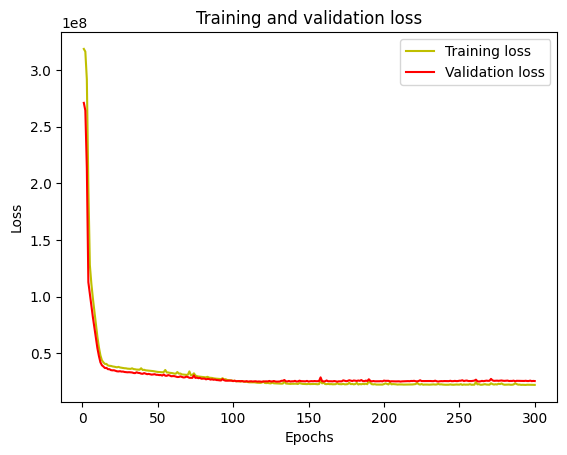

In [74]:
# Evaluate the model:

#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

A quick look at the plot suggets that the model is not learning much after the 150th epoch and the loss seems to plateau after that point. So we may acheive the same results by reducing the number of epochs to 150 in out next model. 

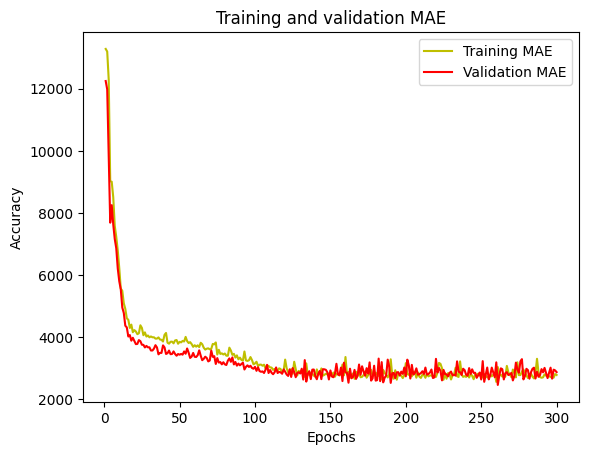

In [75]:
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see again from the plot that the absolute error for training and validation follows closely after the 150th epoch so having 300 epochs may not be necessary after all. 

In [76]:
# predictions on test data:
predictions = optimized_model.predict(X_test[:5]).tolist()
print("Predicted values are: ", predictions)
print("Real values are: ", y_test[:5].values.tolist())

1/1 [==============================] - 0s 28ms/step
Predicted values are:  [[8955.921875], [7153.15087890625], [12687.93359375], [35430.40625], [5437.81884765625]]
Real values are:  [[8688.85885], [5708.867], [11436.73815], [38746.3551], [4463.2051]]


In [77]:
mse_neural, mae_neural = optimized_model.evaluate(X_test, y_test)
print('Mean squared error from neural net: ', mse_neural)
print('Mean absolute error from neural net: ', mae_neural)

9/9 [==============================] - 0s 2ms/step - loss: 21407026.0000 - mae: 2808.6472
Mean squared error from neural net:  21407026.0
Mean absolute error from neural net:  2808.647216796875


We notice an improvement in our model after after a drop out of and having a batch size of 32 and 300 epochs. However, we did not use any regularization in our model building.

So lets implement another model with regularization and reduce the number of epochs because it looks like the model is overfitting as there is no significant improvement after the 150th epoch(based on the graph as noted above).

Before we implement another model, lets use the keras tuner to find the optimal hyperparameters like number of neurons, number of hidden layers, number of dropout nerons which we were't able to find using the grid search. 

In [78]:
def build_regularized_model(hp):
    model = Sequential()
    
    # Tune the number of hidden layers
    hp_layers = hp.Int('num_layers', min_value=1, max_value=4)
    
    # input layer
    model.add(Dense(units=hp.Int('units_0', min_value=32, max_value=512, step=32),
                    activation='relu', input_dim=11, kernel_regularizer=l2(0.01)))
    
    # hidden layers
    for i in range(1, hp_layers):
        # Tune the number of units in this hidden layer
        hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32)
        model.add(Dense(units=hp_units, activation='relu', kernel_regularizer=l2(0.01)))
        
        # Dropout layers
        hp_dropout = hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.5, step=0.1)
        model.add(Dropout(rate=hp_dropout))
    # output layer
    model.add(Dense(1, activation='linear'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model

In [80]:
tuner = keras_tuner.RandomSearch(
    build_regularized_model,
    objective='val_loss',  # Metric to optimize (Mean Squared Error) or we can also minimize the val_loss
    max_trials=10,  # hyperparameter combinations to try
    directory='my_tuning_directory',  # Directory to store tuning results
    project_name='insurance_tuning'  # Folder name
)


In [81]:
# Lets perform the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=125, validation_data=(X_validate, y_validate))

Trial 10 Complete [00h 00m 21s]
val_loss: 34149116.0

Best val_loss So Far: 24046716.0
Total elapsed time: 00h 02m 47s


In [82]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'num_layers': 4,
 'units_0': 512,
 'learning_rate': 0.01,
 'units_1': 160,
 'dropout_1': 0.5,
 'units_2': 224,
 'dropout_2': 0.4,
 'units_3': 192,
 'dropout_3': 0.4}

In [83]:
print(f"The best learning rate is {best_hps.get('learning_rate')}")

The best learning rate is 0.01


In [84]:
# Build the model with the optimal hyperparameters 
final_model = tuner.hypermodel.build(best_hps)


In [85]:
# Training the data on 125 epochs:
history = final_model.fit(X_train, y_train, epochs=150, validation_data=(X_validate, y_validate), batch_size=32)

Epoch 1/150
26/26 [==============================] - 1s 7ms/step - loss: 176218368.0000 - mae: 9524.7900 - val_loss: 52317140.0000 - val_mae: 6275.1045
Epoch 2/150
26/26 [==============================] - 0s 4ms/step - loss: 55240220.0000 - mae: 5016.6084 - val_loss: 37333628.0000 - val_mae: 4609.5142
Epoch 3/150
26/26 [==============================] - 0s 4ms/step - loss: 50277716.0000 - mae: 4745.4102 - val_loss: 35262004.0000 - val_mae: 3851.8120
Epoch 4/150
26/26 [==============================] - 0s 4ms/step - loss: 50789664.0000 - mae: 4691.9814 - val_loss: 33154300.0000 - val_mae: 3575.2134
Epoch 5/150
26/26 [==============================] - 0s 4ms/step - loss: 49923744.0000 - mae: 4485.1631 - val_loss: 32591846.0000 - val_mae: 4460.8462
Epoch 6/150
26/26 [==============================] - 0s 4ms/step - loss: 43875212.0000 - mae: 4399.8774 - val_loss: 30147094.0000 - val_mae: 4066.5630
Epoch 7/150
26/26 [==============================] - 0s 4ms/step - loss: 38265528.0000 - mae:

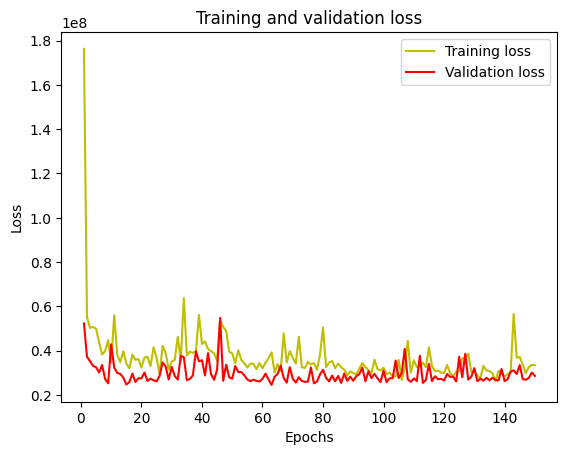

In [86]:
# Evaluate the model:

#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

After fine tuning the hyperparameters, it is very clear that after the 50th epoch there is no significant improvement in the loss. We can implement an early stop with a patience of 20 to prevent the model from overfitting. 

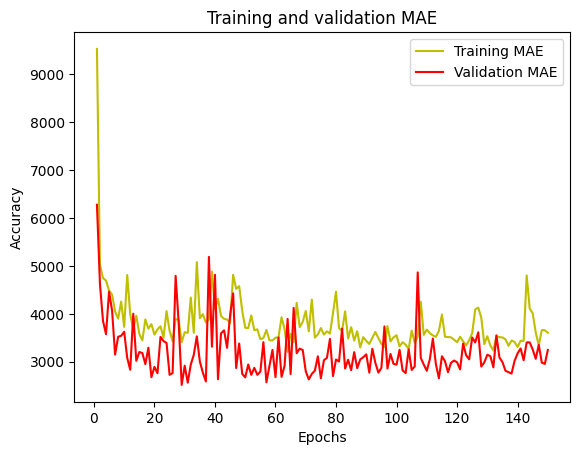

In [87]:
acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
    

Lets make predictions using the final model and compare them with the results that we get after implementing early stopping.

In [88]:
final_model_predictions = final_model.predict(X_test[:5]).tolist()
print("Predicted values are: ", final_model_predictions)
print("Real values are: ", y_test[:5].values.tolist())

1/1 [==============================] - 0s 28ms/step
Predicted values are:  [[9496.4677734375], [4998.29931640625], [12563.3359375], [38652.109375], [6279.5791015625]]
Real values are:  [[8688.85885], [5708.867], [11436.73815], [38746.3551], [4463.2051]]


In [90]:
mse_neural_final, mae_neural_final = final_model.evaluate(X_test, y_test)
print('Mean squared error from neural net: ', mse_neural_final)
print('Mean absolute error from neural net: ', mae_neural_final)

9/9 [==============================] - 0s 2ms/step - loss: 28227580.0000 - mae: 3280.4019
Mean squared error from neural net:  28227580.0
Mean absolute error from neural net:  3280.40185546875


In [94]:
# Lets create a dataframe and compare the mean squared errors and the mean absolute errors of our base model with that of the final model

data = {"mse_base_model" : [mse_neural],
       "mae_neural" : [mae_neural],
       "mse_neural_final" : [mse_neural_final],
       "mae_neural_final" : [mae_neural_final]}

metrics_df = pd.DataFrame(data)

metrics_df

,mse_base_model,mae_neural,mse_neural_final,mae_neural_final
0,34735292.0,3949.414062,28227580.0,3280.401855


When we compare our final model with the base neural network, we see an improvement in the loss. The loss for this model is lower than the previous model. 

In [95]:
# Creating a checkpoint to save our model in case of unforseen events like a power failure so we can resume training using our last saved checkpoints
filepath="best_model.hdf5" #File name includes epoch and validation loss.

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [96]:
# implementing early stopping with a patience of 20 epochs which means that if the model does not see any improvements after 20 epochs, then the model will stop training.:

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

In [97]:
# Lets also log the training data into a csv file so we can compare the training performance
csv_logger = CSVLogger('training.log.csv')

In [98]:
callbacks_list = [checkpoint, early_stop, csv_logger]

Lets find the epoch at which we found our lowest validation loss and reinstantiate our final model with the same number of epochs that gave us the lowest validation loss: 

In [99]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Epoch with lowest validation loss: %d' % (best_epoch,))

Epoch with lowest validation loss: 63


In [100]:
# re instantiate our final model: 
hyper_model = tuner.hypermodel.build(best_hps)

history = hyper_model.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_validate, y_validate), callbacks=callbacks_list, batch_size=32)


Epoch 1/63
15/26 [================>.............] - ETA: 0s - loss: 223302928.0000 - mae: 10815.3096 
Epoch 1: val_loss improved from inf to 44644360.00000, saving model to best_model.hdf5
26/26 [==============================] - 1s 8ms/step - loss: 167504288.0000 - mae: 9260.5879 - val_loss: 44644360.0000 - val_mae: 4406.7017
Epoch 2/63
16/26 [=================>............] - ETA: 0s - loss: 54152108.0000 - mae: 4815.3584
Epoch 2: val_loss improved from 44644360.00000 to 42723524.00000, saving model to best_model.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 51498436.0000 - mae: 4785.4521 - val_loss: 42723524.0000 - val_mae: 3805.8308
Epoch 3/63
 1/26 [>.............................] - ETA: 0s - loss: 55405308.0000 - mae: 4510.0801

/home/momo/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/26 [===================>..........] - ETA: 0s - loss: 54454188.0000 - mae: 4741.9365
Epoch 3: val_loss improved from 42723524.00000 to 35210896.00000, saving model to best_model.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 50964024.0000 - mae: 4585.1411 - val_loss: 35210896.0000 - val_mae: 3472.7031
Epoch 4/63
18/26 [===================>..........] - ETA: 0s - loss: 46167020.0000 - mae: 4244.4756
Epoch 4: val_loss did not improve from 35210896.00000
26/26 [==============================] - 0s 4ms/step - loss: 48210708.0000 - mae: 4355.3335 - val_loss: 56417644.0000 - val_mae: 5864.2246
Epoch 5/63
18/26 [===================>..........] - ETA: 0s - loss: 56453608.0000 - mae: 4707.4707
Epoch 5: val_loss improved from 35210896.00000 to 32565722.00000, saving model to best_model.hdf5
26/26 [==============================] - 0s 5ms/step - loss: 52877732.0000 - mae: 4681.2441 - val_loss: 32565722.0000 - val_mae: 3229.8074
Epoch 6/63
19/26 [====================>........

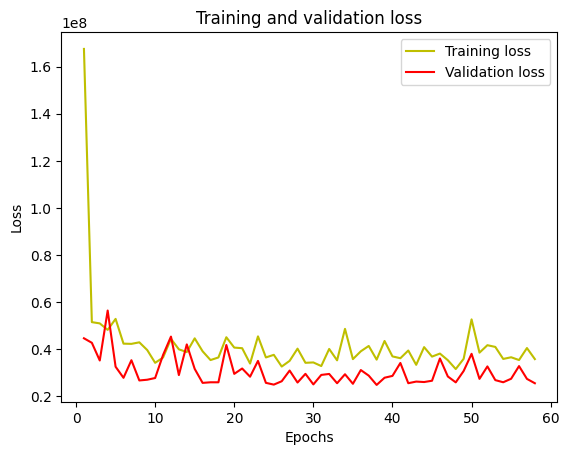

In [101]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

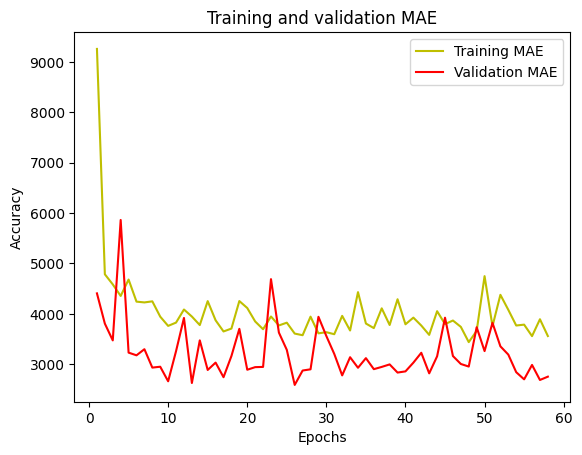

In [102]:
#plot the training and validation mae at each epoch

acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [103]:
hyper_model_predictions = hyper_model.predict(X_test[:5]).tolist()
print("Predicted values are: ", hyper_model_predictions)
print("Real values are: ", y_test[:5].values.tolist())

1/1 [==============================] - 0s 33ms/step
Predicted values are:  [[9445.328125], [5986.1591796875], [12035.0537109375], [36521.28125], [5700.9208984375]]
Real values are:  [[8688.85885], [5708.867], [11436.73815], [38746.3551], [4463.2051]]


In [104]:
mse_neural_hypermodel, mae_neural_hypermodel = hyper_model.evaluate(X_test, y_test)
print('Mean squared error from neural net: ', mse_neural_hypermodel)
print('Mean absolute error from neural net: ', mae_neural_hypermodel)

9/9 [==============================] - 0s 3ms/step - loss: 21526634.0000 - mae: 2568.7080
Mean squared error from neural net:  21526634.0
Mean absolute error from neural net:  2568.7080078125


### Lets load our best saved model to make predictions:

In [109]:
# Lets load our best saved model to make predictions:
loaded_model = tf.keras.models.load_model(filepath)

In [110]:
loaded_model_predictions = loaded_model.predict(X_test[:5]).tolist()
print("Predicted values are: ", loaded_model_predictions)
print("Real values are: ", y_test[:5].values.tolist())

1/1 [==============================] - 0s 30ms/step
Predicted values are:  [[9894.95703125], [6923.3095703125], [13483.748046875], [33286.796875], [5358.9814453125]]
Real values are:  [[8688.85885], [5708.867], [11436.73815], [38746.3551], [4463.2051]]


In [111]:
mse_neural_loaded, mae_neural_loaded = loaded_model.evaluate(X_test, y_test)
print('Mean squared error from neural net: ', mse_neural_loaded)
print('Mean absolute error from neural net: ', mae_neural_loaded)

9/9 [==============================] - 0s 2ms/step - loss: 21713090.0000 - mae: 2962.8164
Mean squared error from neural net:  21713090.0
Mean absolute error from neural net:  2962.81640625


It looks like our hypermodel is the best performer outperforming the best loaded model.

## 4.Use TensorBoard for visualization of model performance

In [112]:
# lets visualize our hypermodel by retraining it for tensorboard visualization:

# retraining the saved model:

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = hyper_model.fit(X_train, y_train ,verbose=1, epochs=49, batch_size=32,
                     validation_data=(X_validate, y_validate), callbacks=[tensorboard_callback])


Epoch 1/49
26/26 [==============================] - 0s 10ms/step - loss: 35852860.0000 - mae: 3698.4851 - val_loss: 31136086.0000 - val_mae: 2875.9053
Epoch 2/49
26/26 [==============================] - 0s 6ms/step - loss: 33038238.0000 - mae: 3642.5068 - val_loss: 26723168.0000 - val_mae: 2772.9355
Epoch 3/49
26/26 [==============================] - 0s 5ms/step - loss: 32462204.0000 - mae: 3392.9573 - val_loss: 33798908.0000 - val_mae: 2998.8953
Epoch 4/49
26/26 [==============================] - 0s 5ms/step - loss: 49768240.0000 - mae: 4553.2158 - val_loss: 33559632.0000 - val_mae: 3280.9153
Epoch 5/49
26/26 [==============================] - 0s 7ms/step - loss: 38692068.0000 - mae: 3863.8486 - val_loss: 30558792.0000 - val_mae: 2980.5134
Epoch 6/49
26/26 [==============================] - 0s 5ms/step - loss: 39917232.0000 - mae: 3925.4307 - val_loss: 26081730.0000 - val_mae: 2704.5916
Epoch 7/49
26/26 [==============================] - 0s 5ms/step - loss: 36965496.0000 - mae: 3769.8

In [113]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

### 5. Write a conclusion and recommendation

Conclusion: The insurance dataset is a small dataset consisting of only 1337 records or rows. It includes both categorical and numerical features. The categorical features include ['sex', 'smoker', 'region'], while the numerical features include ['age', 'bmi', 'children', 'charges'].

The independent feature is the charges class which is being predicted and the others are the dependent features. Its important to note that since our target class in a continuous number, we are working with a regression problem. 

The insurance dataset is loaded as a pandas data frame and subsequent data pre processing steps were performed which included looking for missing values and checking for duplicates. One duplicate row was found which was deleted. The categorical and the numerical features were then separated to be scaled and encoded. 

The categorical features were found to be nominal in nature and as such one hot encoding was used to encode the categorical features. One hot encoding does not create an order for the categories and does not interfere with the order of the categorical features.

During the exploratory data analysis stage, we found that the data consisted predominantly of non smokers compared to smokers and the region that had the greatest number of smokers was found to be from the southeast region. We were also able to infer that smokers paid the highest charges which was confirmed when the different regions and their average charges were plotted and the southeast region had the highest average charges. Some other important characteristics were also found like the correlation between the different attributes and their effect on the charges class. For example, it was also found that people paid more charges as they aged and people that were smokers paid more in charges. 

A pair plot of all the numerical features was used to understand their distribution and their correlation to the target class of charge. It was found that the features did not follow a normal distribution. Some attributes were right skewed, while some were left skewed and the distribution was not gaussian. For this reason, MinMaxScaler was used to scale the numerical attributes. 

After encoding our categorical features and scaling our numerical features, we notice that all our independent features are scaled to be between the range (0-1). The values charges, our target class are not between the same scale and as a result follow a different scale which results in a high value for loss. 

The dataset was divided into train (.60), test(.20) and validate(.20) sets 

The mean absolute error means that in average, for all the values, the model is off by  $ 2568 This means that on average each prediction is only off by about 14.8 dollars. (3971/268) = $9.58 An analysis of the loss and the mean absolute error also suggests that the model’s loss does not go down much after the 40th epoch and starts to plateau which gives us an idea of how many epochs to run the model with. 

A second model was built using keras regressor which implemented a grid search to help find the hyperparameters. However the grid search is limited to only finding the number of epochs, batch_size and the optimizer. After running the grid search it was found that the model was using hyperparameters values which suggested overfitting. 

A keras tuner was also used which helped find the best number of hyper parameters like number of neurons, number of hidden layers. It was found that the loss was the lowest at epoch# 63 which confirmed our suspicion that the model is not learning much after the 41th epoch and we don’t need to run it for more than 41 epochs. The final model was found to perform better.


Recommendation: 

Since the architechture of neural network is designed for huge datasets, the only recommendation is to increase the size of the dataset by getting more relevant data. This will help the neural network model learn the patterns more efficiently and perform better. 
